# 训练思路

Logic：仅预测撂荒地上光伏建设概率即可，加入多时序可以丰富样本信息、学习到增量样本表示

数据流：


输入：
1、训练样本（划分训练集、测试集合）：美国光伏正样本；
2、预测样本：美国光伏用地；

输出：得到

数据操作：

（先用QQ图观察各个数据的分布特征）对于符合正态分布特征可以直接进入聚类；

1、样本标准化；
2、


后期数据补齐（后期模型优化需要注意的point）
1、Y数据源统一的问题；
2、R语言包问题解决；d
3、提取光伏Y=1正标签对应的landcover序列

# Load Data

In [1]:
%load_ext autoreload
%autoreload 2 
from function import *
import pandas as pd
import geopandas as gpd
from typing import Sequence
import numpy as np


abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': r"D:\xarray\merged_chunk_2\*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': r'data\sheng2022.shp',
    'World_shp': r'data\main_ADM_0.shp', 
    'us_abandon': r'data\us_abandon_clean.csv',
    'us_pv_embedding': r'data\training_embedding.csv'
}

ZERO_COLS = [
     'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp'
]

YEARS = [2018, 2020]

NUMERIC_FEATURES = [
    'lat','lon','GDPpc', 'GDPtot', 'GURdist', 'DEM','Slope',
    'Population','Powerdist','PrimaryRoad','SecondaryRoad','TertiaryRoad',
    'gdmp','rsds','tas','wind'
]
CAT_COLS = ['landcover']

ABANDON_COLS = ['abandonment_year','abandonment_duration', 'current_abandonment']

NONE_ABANDON_COLS = ['recultivation']

time=['2018-01-01','2020-01-01']





gogogo
[OK] TensorFlow available
[OK] scikeras available
[OK] SHAP available


# Version1（最初版本）

In [ ]:
# -*- coding: utf-8 -*-
"""
Run GMM environment scoring on US mainland points.
- 使用第二次裁剪后的 df_embedding_fill[features_no_coords] 训练
- 对 df_abandon_filtered[features_no_coords] 打分
- 仅保存最终结果（含 merge_id 列，便于与原数据拼接）
- 输出关键性能图表（密度分布、得分分布、密度-得分散点）
"""

from function import *  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped


if __name__ == '__main__':
    np.random.seed(42)

    # ---------------------------
    # 0) 基础地理范围与底图
    # ---------------------------
    usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
    us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

    # ---------------------------
    # 1) 读取数据
    # ---------------------------
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])

    # 初步经纬度范围过滤
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 第二次用州界矢量更精确裁剪
    df_abandon = clip_data_with_us_states(df_abandon, us_states)
    df_embedding = clip_data_with_us_states(df_embedding, us_states)

    # ---------------------------
    # 2) 缺失值填充 + 去重
    # ---------------------------
    df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

     # ---------------------------
    # 3) 特征选择（排除经纬度）
    # ---------------------------
    features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]

    # 为稳妥，取交集（防止列名不在 DataFrame 中导致 KeyError）
    features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]
    print(f"使用的特征数量: {len(features_no_coords)}")
    print(f"特征列表: {features_no_coords}")

    # ---------------------------
    # 4) 训练修复版本的GMM（解决数据泄露）
    # ---------------------------
    print("\n开始训练修复版本的GMM模型...")
    gmm_pipeline = select_and_train_gmm(df_embedding_fill[features_no_coords],use_bic=True)

    print("✅ 修复版本GMM模型训练完成！")

    # # 训练完成后，计算并保存标定参数（测试一致性，慎用！！！）
    # print("\n计算并保存标定参数...")

    # X_train_processed = gmm_pipeline.named_steps['preprocessor'].transform(df_embedding_fill[features_no_coords])
    # gmm_trained = gmm_pipeline.named_steps['gmm']
    # logdens_train = gmm_trained.score_samples(X_train_processed)

    # # 保存标定参数到pipeline
    # calibration_stats = {
    #     'mu': float(logdens_train.mean()),
    #     'mean': float(logdens_train.mean()),
    #     'std': float(logdens_train.std()),
    #     'min': float(logdens_train.min()),
    #     'max': float(logdens_train.max()),
    #     'n_samples': len(logdens_train),
    #     'method': 'sigmoid',
    #     'sigmoid_alpha': 1.0
    # }

    # # 将标定参数附加到pipeline
    # gmm_pipeline.calibration_ = calibration_stats

    # print(f"✅ 标定参数已保存:")
    # print(f"   均值: {calibration_stats['mu']:.6f}")
    # print(f"   标准差: {calibration_stats['std']:.6f}")
    # print(f"   范围: [{calibration_stats['min']:.6f}, {calibration_stats['max']:.6f}]")

    # ---------------------------
    # 5) 使用修复版本进行环境评分
    # ---------------------------
    print("\n开始环境相似度评分...")

    # 使用你的 score_env函数
    dens, env_scores, stats = score_env(
        gmm_pipeline, 
        df_abandon_filtered[features_no_coords],
        method='sigmoid',
        sigmoid_alpha=0.2,
        reference_stats=None,  
        return_logdens=False
    )

    print("✅ 环境相似度得分计算完成！")
    print(f"密度范围: [{dens.min():.6f}, {dens.max():.6f}]")
    print(f"环境分数范围: [{env_scores.min():.6f}, {env_scores.max():.6f}]")
    print(f"标定来源: {stats.get('calibration_source', '未知')}")
    print(f"使用的标定均值: {stats['mu']:.6f}")

    # ---------------------------
    # 6) 一致性验证测试
    # ---------------------------
    # print("\n进行一致性验证测试...")

    # # 测试样本
    # test_sample = df_abandon_filtered[features_no_coords].head(1000)

    # # 第一次预测
    # dens1, scores1, stats1 = score_env(
    #     gmm_pipeline, 
    #     test_sample,
    #     method='sigmoid',
    #     sigmoid_alpha=1.0
    # )

    # # 第二次预测（应该完全一致）
    # dens2, scores2, stats2 = score_env(
    #     gmm_pipeline, 
    #     test_sample,
    #     method='sigmoid',
    #     sigmoid_alpha=1.0
    # )

    # # # 检查一致性
    # # dens_consistent = np.allclose(dens1, dens2, rtol=1e-10)
    # # scores_consistent = np.allclose(scores1, scores2, rtol=1e-10)

    # print(f"✅ 密度预测一致性: {dens_consistent}")
    # print(f"✅ 分数预测一致性: {scores_consistent}")

    # if dens_consistent and scores_consistent:
    #     print("🎉 完美！预测结果完全一致")
    # else:
    #     print("⚠️ 警告：预测结果不一致，请检查")

    # ---------------------------
    # 6) 保存最终结果（含 merge_id 便于回拼）
    # ---------------------------
    save_dir = "data/US_data"
    os.makedirs(save_dir, exist_ok=True)
    # 将环境分数和密度等结果与原始数据通过 'lat' 和 'lon' 两列组合 merge 合并输出
    # 构建结果DataFrame
    results = pd.DataFrame({
        'lon': df_abandon_filtered['lon'].values,
        'lat': df_abandon_filtered['lat'].values,
        'gmm_density': dens,
        'gmm_env_score': env_scores,
    })

    # 将results merge到df_abandon_filtered
    df_abandon_filtered = pd.merge(
        df_abandon_filtered,
        results[['lat', 'lon', 'gmm_density', 'gmm_env_score']],
        on=['lat', 'lon'],
        how='left'
    )

    # 输出合并后的结果
    df_abandon_filtered.to_csv('data/US_data/abandon_filtered_with_gmm_scores.csv', index=False)

    print(f"✅ Results saved: data/US_data/abandon_filtered_with_gmm_scores.csv")
    print("(Use merge_id to join with original data by index, or spatial join with lat/lon)")


    # ---------------------------
    # 7) 相似性可视化诊断（log-density / PIT / PCA / Mahalanobis）
    # ---------------------------
    print("\nRunning similarity diagnostics (log-density/PIT/PCA/MD²)...")
    try:
        # 以 df_embedding_fill 作为参考正样本；df_abandon_filtered 作为待评数据
        diag_out = visualize_similarity_diagnostics(
            gmm_pipeline,
            df_ref_pos=df_embedding_fill[features_no_coords],
            df_query=df_abandon_filtered[features_no_coords],
            q_cut=0.05,            # 参考集5%分位阈值（可改成0.10或0.01）
            max_points_pca=8000,   # PCA投影用于可视化的最大采样数
            random_state=42
        )

        # 立即保存当前生成的诊断图
        diag_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        diag_path = os.path.join(save_dir, f"similarity_diagnostics_{diag_ts}.png")
        plt.gcf().savefig(diag_path, dpi=300, bbox_inches='tight')
        print(f"✅ Similarity diagnostics saved: {diag_path}")
        print(f"   5% 阈值(log p): {diag_out['logp_threshold_value']:.6f} | "
              f"ref μ={diag_out['logp_ref_mean']:.6f}, σ={diag_out['logp_ref_std']:.6f}")

        # 可选：如果你不想重复显示，保存后可以关闭当前图
        # plt.close()

    except NameError as e:
        print("⚠️ 找不到 visualize_similarity_diagnostics，请确认该函数已在 function.py 或本文件中定义。")
        print(f"   详细信息: {e}")
    except Exception as e:
        print(f"⚠️ 相似性诊断绘图失败: {e}")



    # ---------------------------
    # 7) 测试模型加载和预测
    # ---------------------------
    # print("\n测试模型加载和预测...")
    
    # # 假设模型文件名（根据实际训练结果调整）
    # model_files = [f for f in os.listdir('.') if f.startswith('gmm_model_') and f.endswith('_fixed.pkl')]
    
    # if model_files:
    #     model_filename = model_files[0]  # 选择第一个匹配的文件
    #     print(f"找到保存的模型: {model_filename}")
        
    #     # 测试样本
    #     test_sample = df_abandon_filtered[features_no_coords].head(1000)

    #     print("\n方法1：使用 predict_with_saved_pipeline_v2")
    #     dens_loaded, scores_loaded, stats_loaded = predict_with_saved_pipeline_v2(
    #         test_sample, 
    #         model_filename, 
    #         method='sigmoid',
    #         sigmoid_alpha=1.0,
    #         return_stats=True
    #     )
        
    #     if dens_loaded is not None:
    #         print(f"✅ 模型加载测试成功！")
    #         print(f"测试样本预测密度范围: [{dens_loaded.min():.6f}, {dens_loaded.max():.6f}]")
    #         print(f"测试样本预测分数范围: [{scores_loaded.min():.6f}, {scores_loaded.max():.6f}]")
    #         print(f"标定来源: {stats_loaded.get('calibration_source', '未知')}")
            
    #         # 验证一致性（前1000个样本）
    #         original_dens = dens[:1000]
    #         original_scores = env_scores[:1000]
    #         consistency_dens = np.allclose(original_dens, dens_loaded, rtol=1e-6)
    #         consistency_scores = np.allclose(original_scores, scores_loaded, rtol=1e-6)
            
    #         print(f"密度预测一致性: {consistency_dens}")
    #         print(f"分数预测一致性: {consistency_scores}")
            
    #         if consistency_dens and consistency_scores:
    #             print("🎉 完美！预测结果完全一致")
    #         else:
    #             print("ℹ️ 注意：可能由于不同的标定参数导致轻微差异")
    #     else:
    #         print("⚠️ 模型加载测试失败")
    

    # ---------------------------
    # 8) 关键性能图表
    # ---------------------------
    print("\nGenerating key performance plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Density distribution
    axes[0, 0].hist(dens, bins=60, alpha=0.8, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('GMM Density Distribution (Fixed Version)')
    axes[0, 0].set_xlabel('Density')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3)

    # Environment score distribution
    axes[0, 1].hist(env_scores, bins=60, alpha=0.8, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Environment Similarity Score Distribution (Fixed Version)')
    axes[0, 1].set_xlabel('Env Score')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(True, alpha=0.3)

    # Density vs. Score
    axes[1, 0].scatter(dens, env_scores, s=4, alpha=0.6, c='coral')
    axes[1, 0].set_title('Density vs. Environment Score (Fixed Version)')
    axes[1, 0].set_xlabel('Density')
    axes[1, 0].set_ylabel('Env Score')
    axes[1, 0].grid(True, alpha=0.3)

    # Spatial sampling visualization
    sample_n = min(2000, len(results))
    idx = np.random.choice(len(results), sample_n, replace=False)
    sc = axes[1, 1].scatter(results.loc[idx, 'lon'], results.loc[idx, 'lat'],
                            c=results.loc[idx, 'gmm_env_score'].values, s=6, alpha=0.8, cmap='viridis')
    axes[1, 1].set_title('Spatial Distribution of Environment Score (Fixed Version)')
    axes[1, 1].set_xlabel('Longitude')
    axes[1, 1].set_ylabel('Latitude')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(sc, ax=axes[1, 1], label='Env Score')

    plt.suptitle('GMM Environment Scoring Results - Fixed Version', fontsize=16, y=0.98)
    plt.tight_layout()
    
    # 保存图表
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_path = os.path.join(save_dir, f"gmm_env_key_plots_fixed_{timestamp}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plots saved: {fig_path}")
    plt.show()

    # ---------------------------
    # 9) 模型信息总结
    # ---------------------------
    # print("\n" + "=" * 60)
    # print("模型信息总结:")
    # print("=" * 60)
    
    # if gmm_pipeline:
    #     # 获取预处理器信息
    #     preprocessor = gmm_pipeline.named_steps['preprocessor']
    #     feature_info = preprocessor.get_feature_info()
        
    #     # 获取GMM信息
    #     gmm = gmm_pipeline.named_steps['gmm']
        
    #     print(f"✅ 使用修复版本Pipeline，解决数据泄露问题")
    #     print(f"✅ GMM组件数: {gmm.n_components}")
    #     print(f"✅ 协方差类型: {gmm.covariance_type}")
    #     print(f"✅ 分类特征信息: {feature_info}")
    #     print(f"✅ 训练样本数: {len(df_embedding_fill)}")
    #     print(f"✅ 预测样本数: {len(df_abandon_filtered)}")
    #     print(f"✅ 特征数量: {len(features_no_coords)}")
        
        # if model_files:
        #     print(f"✅ 模型文件: {model_files[0]}")
        
    print("=" * 60)

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
使用的特征数量: 15
特征列表: ['GDPpc', 'GDPtot', 'GURdist', 'DEM', 'Slope', 'Population', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

开始训练修复版本的GMM模型...
输入数据形状: (10472, 15)

检查 landcover 分布:
唯一值: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
分布: {1.0: 1946, 2.0: 1444, 3.0: 1078, 4.0: 1750, 5.0: 1490, 6.0: 790, 7.0: 1904, 8.0: 64, 9.0: 6}

 创建组合预处理器...
测试预处理器...
预处理后特征形状: (10472, 23)
数据形状: (10472, 23)
NaN值数量: 0
Inf值数量: 0
零值数量: 83776
方差范围: [5.73e-04, 1.00e+00]
零方差特征数: 0 ；低方差特征数: 0
协方差矩阵条件数: 4.14e+12
最小/最大特征值: 1.00e-12 / 4.14e+00

构建完整Pipeline（包含预处理器）...
使用BIC作为评分标准

开始训练...


GMM训练:   0%|          | 0/44 [00:00<?, ?it/s]

Fitting 5 folds for each of 44 candidates, totalling 220 fits


In [ ]:
df_abandon_filtered.gmm_env_score.describe()

count    7.177000e+04
mean     9.967257e-01
std      5.712856e-02
min      1.928750e-22
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: gmm_env_score, dtype: float64

## GMM估计输出数据检查

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值

[载入模型] gmm_model_34c_fixed.pkl ...
✅ GMM pipeline loaded.
Running similarity diagnostics (log-density/PIT/PCA/MD²)...


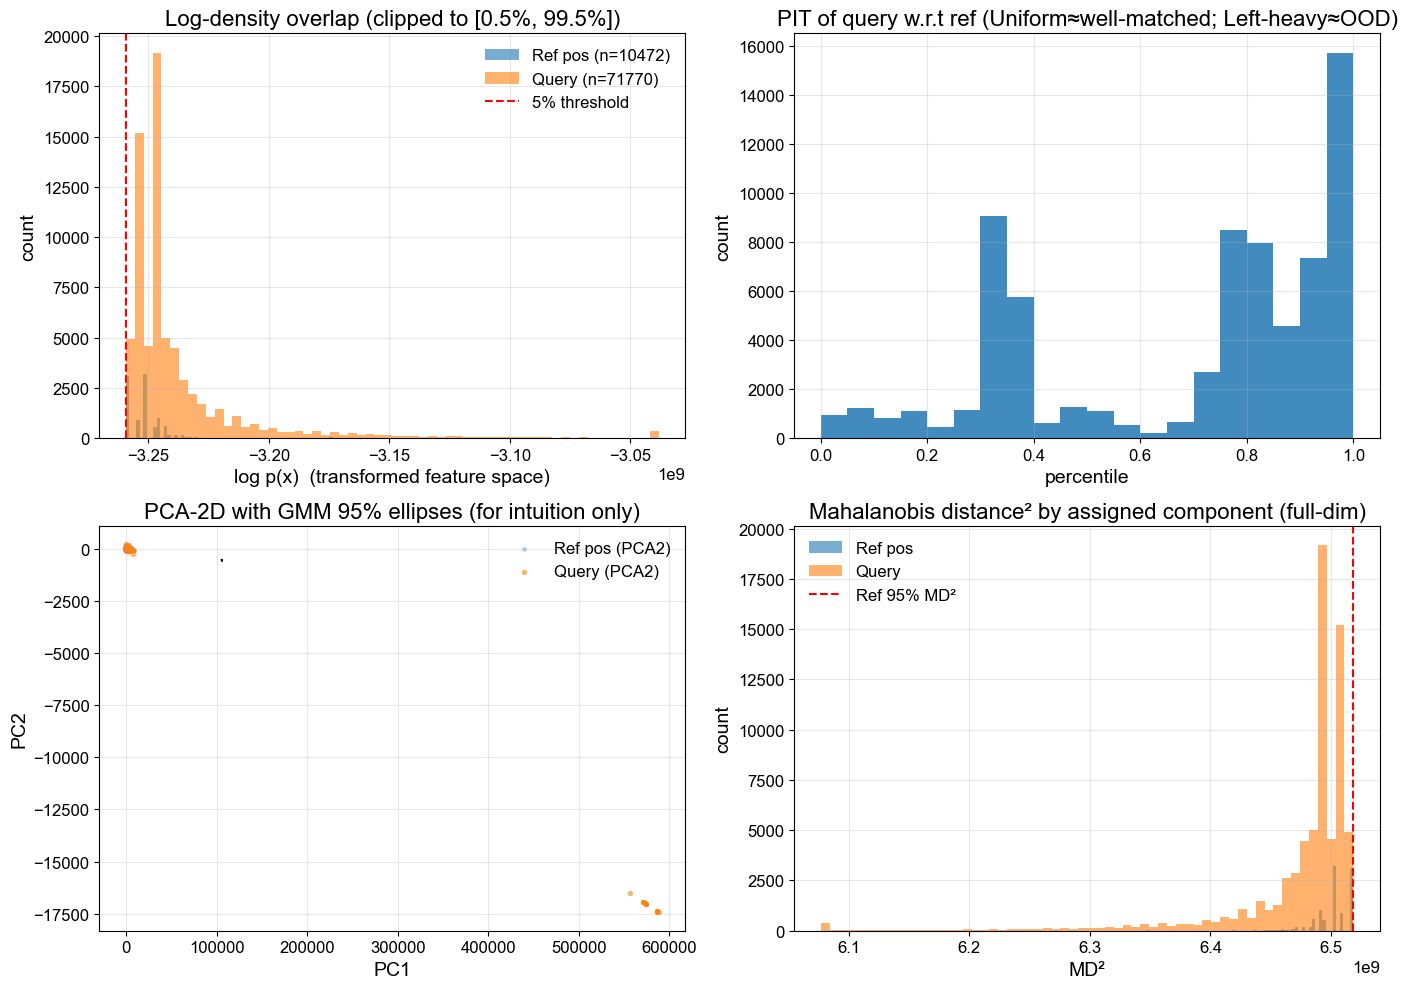


                    相似性诊断详细报告

📊 数据概览:
  参考正样本: 10,472 个
  查询样本: 71,770 个

🎯 基于Log-Density的相似性分层:
  🔥 极度相似 (>95%分位): 15,739 个 (21.9%)
  ✨ 高度相似 (75%-95%): 28,381 个 (39.5%)
  📈 中等相似 (25%-75%): 23,067 个 (32.1%)
  ⚠️ 低度相似 (5%-25%): 3,615 个 (5.0%)
  ❌ 异常值 (<5%分位): 968 个 (1.3%)

🎲 概率积分变换(PIT)分析:
  均匀性偏离度: 6589.000 (越小越好, <3588.5为良好)
  左偏重比例: 5.7% (高值表示查询样本偏离参考分布)
  右偏重比例: 49.6%
  PIT分布上下四分位数: Q1=0.373 ± 0.002 (95%CI: 0.370 ~ 0.376)
                      Q2/中位数=0.798 ± 0.001 (95%CI: 0.795 ~ 0.801)
                      Q3=0.939 ± 0.002 (95%CI: 0.936 ~ 0.943)
  PIT均值: 0.693 ± 0.001 (95%CI: 0.691 ~ 0.695)

📏 马氏距离统计:
  中位数以内: 68.7%
  90%分位以内: 96.9%
  95%分位以内: 98.7%
  异常值(>99%): 0.7%

🏆 综合相似性评分:
  Log-density得分: 20.2/100
  PIT均匀性得分: 8.2/100
  马氏距离得分: 96.9/100
  ⭐ 总体相似性: 39.6/100
  📝 解释: 🔴 较差 - 查询样本明显偏离参考分布

💡 实际应用意义:
  ✅ 98.7%的撂荒地具有与已建光伏高度相似的环境特征
  🎯 建议优先开发: 15,739个极度相似 + 28,381个高度相似地点
✅ Similarity diagnostics saved: data/US_data\similarity_diagnostics_20251028_110757.png
   5% 阈值(log p): -32593

<Figure size 640x480 with 0 Axes>

In [ ]:

import joblib
from function import *  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime


def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped



np.random.seed(42)

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

    # ---------------------------
# 3) 特征选择（排除经纬度）
# ---------------------------
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]

# 为稳妥，取交集（防止列名不在 DataFrame 中导致 KeyError）
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]
print("\n[载入模型] gmm_model_34c_fixed.pkl ...")
try:
    gmm_pipeline = joblib.load("gmm_model_34c_fixed.pkl")
    print("✅ GMM pipeline loaded.")
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    raise

print("Running similarity diagnostics (log-density/PIT/PCA/MD²)...")
try:
    diag_out = visualize_similarity_diagnostics(
        gmm_pipeline,
        df_ref_pos=df_embedding_fill[features_no_coords],
        df_query=df_abandon_filtered[features_no_coords],
        q_cut=0.05,
        max_points_pca=8000,
        random_state=42
    )
    diag_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    diag_path = os.path.join(save_dir, f"similarity_diagnostics_{diag_ts}.png")
    plt.gcf().savefig(diag_path, dpi=300, bbox_inches='tight')
    print(f"✅ Similarity diagnostics saved: {diag_path}")
    print(f"   5% 阈值(log p): {diag_out['logp_threshold_value']:.6f} | "
          f"ref μ={diag_out['logp_ref_mean']:.6f}, σ={diag_out['logp_ref_std']:.6f}")
except NameError as e:
    print("⚠️ 找不到 visualize_similarity_diagnostics，请确认该函数已在 function.py 或本文件中定义。")
    print(f"   详细信息: {e}")
except Exception as e:
    print(f"⚠️ 相似性诊断绘图失败: {e}")

# Version 2（深度学习版本）

## Data loading


GPU版本命令
msl
cd /mnt/c/Dev/Landuse_Zhong_clean
source ~/bayes-gpu/bin/activate


验证环境
python -c "import tensorflow as tf; print('TF:', tf.__version__); print('GPU:', tf.test.is_gpu_available())"
python -c "import jax; print('JAX devices:', jax.devices())"


jupyter notebook --no-browser --port=8888

tail -f jupyter.log



In [1]:
from function import *  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime
import platform

def normalize_path(path):
    """
    跨平台路径规范化
    将Windows路径中的反斜杠转换为正斜杠（在Linux/WSL中）
    Windows: r'data\file.shp' -> r'data\file.shp' (保持不变)
    Linux/WSL: r'data\file.shp' -> 'data/file.shp' (转换)
    """
    if isinstance(path, str):
        # 检测是否在WSL或Linux环境中
        is_linux = platform.system() in ['Linux', 'Darwin']
        
        if is_linux:
            # 在Linux/WSL中，将反斜杠转为正斜杠
            path = path.replace('\\', '/')
        
        return path
    return path

def normalize_paths_dict(paths_dict):
    """
    规范化路径字典中的所有路径
    """
    normalized = {}
    for key, value in paths_dict.items():
        normalized[key] = normalize_path(value)
    return normalized

PATHS = normalize_paths_dict(PATHS)
us_nation = gpd.read_file(normalize_path(r'data\US_data\cb_2018_us_nation_5m.shp'))

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped


if __name__ == '__main__':

    # ---------------------------
    # 0) 基础地理范围与底图
    # ---------------------------
    usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)


    # ---------------------------
    # 1) 读取数据
    # ---------------------------
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])

    # 初步经纬度范围过滤
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    df_abandon = df_abandon[
        (df_abandon['lon'] >= usa_bounds_main['lon_min']) &
        (df_abandon['lon'] <= usa_bounds_main['lon_max']) &
        (df_abandon['lat'] >= usa_bounds_main['lat_min']) &
        (df_abandon['lat'] <= usa_bounds_main['lat_max'])
    ]
    # 第二次用州界矢量更精确裁剪
    df_abandon = clip_data_with_us_states(df_abandon, us_nation)
    df_embedding = clip_data_with_us_states(df_embedding, us_nation)

    # ---------------------------
    # 2) 缺失值填充 + 去重
    # ---------------------------
    df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

    # ---------------------------
    # 3) 特征选择（排除经纬度）
    # ---------------------------
    features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
    # 只保留在 df_embedding_fill 列中实际存在的特征（防止有些特征名在数据中不存）
    features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

    

gogogo


I0000 00:00:1765476873.165783     660 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765476873.700318     660 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765476876.009624     660 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[OK] TensorFlow available
[OK] scikeras available
[OK] SHAP available
You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值


In [2]:
# ========== 环境配置 ==========
import warnings
import os
import sys

# 1. 设置环境变量
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 2. 直接重定向stderr（临时）
_old_stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

# 3. 导入matplotlib和tensorflow
try:
    import matplotlib
    import matplotlib.font_manager as fm
    matplotlib.rcParams['font.family'] = 'DejaVu Sans'
    
    import tensorflow as tf
    tf.get_logger().setLevel('ERROR')
finally:
    # 4. 恢复stderr
    sys.stderr.close()
    sys.stderr = _old_stderr

# 5. 设置警告过滤
import sklearn
warnings.filterwarnings('ignore', category=sklearn.base.InconsistentVersionWarning)
warnings.filterwarnings('ignore', module='matplotlib')


import os
import time
import tensorflow as tf

print("="*80)
print("GPU环境配置检查 - WSL Ubuntu + bayes-gpu")
print("="*80)

# ---------------------------
# 0. 基本信息（可选）
# ---------------------------
print(f"TensorFlow 版本: {tf.__version__}")
# 尝试打印构建时 CUDA/cuDNN 版本（不同版本字段名可能不同）
try:
    from tensorflow.sysconfig import get_build_info
    bi = get_build_info()
    print("CUDA build:", bi.get("cuda_version"))
    print("cuDNN build:", bi.get("cudnn_version"))
except Exception:
    pass

# ---------------------------
# 1. 检查并配置 GPU
# ---------------------------
physical_gpus = tf.config.list_physical_devices("GPU")
if physical_gpus:
    print(f"\n✅ 检测到 {len(physical_gpus)} 个 GPU:")
    # 先配置显存策略（必须在任何 GPU 初始化之前）
    try:
        for g in physical_gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print("✅ GPU 显存动态增长已启用")
    except RuntimeError as e:
        print(f"⚠️ 显存动态增长设置失败（可能已初始化）：{e}")

    # 打印设备细节
    for i, g in enumerate(physical_gpus):
        print(f"   GPU {i}: {g.name}")
        try:
            det = tf.config.experimental.get_device_details(g)
            # 常见键：'device_name', 'compute_capability'
            print(f"       设备详情: {det}")
        except Exception:
            pass
else:
    print("\n⚠️ 未检测到 GPU，将使用 CPU")

# ---------------------------
# 2. 小测试：GPU 计算与计时
# ---------------------------
print("\n" + "="*80)
print("GPU性能测试")
print("="*80)

use_gpu = len(physical_gpus) > 0
device_str = "/GPU:0" if use_gpu else "/CPU:0"

# 暖机（避免第一次调用的加载开销影响计时）
with tf.device(device_str):
    _ = tf.matmul(tf.random.normal([256, 256]), tf.random.normal([256, 256]))  # warm-up
    _ = tf.matmul(tf.random.normal([256, 256]), tf.random.normal([256, 256]))  # warm-up

# 计时测试（确保同步）
size = 2000  # 如需更明显差异可调大到 4096
with tf.device(device_str):
    a = tf.random.normal([size, size])
    b = tf.random.normal([size, size])
    t0 = time.time()
    c = tf.matmul(a, b)
    _ = c.numpy()  # 同步到主机，确保计时真实
    elapsed_ms = (time.time() - t0) * 1000

print(f"✅ 设备: {device_str}")
print(f"✅ 矩阵乘法 {size}x{size} 耗时: {elapsed_ms:.2f} ms")
if use_gpu:
    print("🚀 GPU 加速正常（与 CPU 相比应明显更快）")
print("="*80)


GPU环境配置检查 - WSL Ubuntu + bayes-gpu
TensorFlow 版本: 2.21.0-dev20251017
CUDA build: 12.5.1
cuDNN build: 9

✅ 检测到 1 个 GPU:
✅ GPU 显存动态增长已启用
   GPU 0: /physical_device:GPU:0
       设备详情: {'compute_capability': (12, 0), 'device_name': 'NVIDIA GeForce RTX 5080 Laptop GPU'}

GPU性能测试
✅ 设备: /GPU:0
✅ 矩阵乘法 2000x2000 耗时: 20.60 ms
🚀 GPU 加速正常（与 CPU 相比应明显更快）


W0000 00:00:1765476884.512992     660 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1765476884.515404     660 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1765476884.693489     660 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13159 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5080 Laptop GPU, pci bus id: 0000:02:00.0, compute capability: 12.0a


## 选择式采样+Transformer


场景1: 选择式采样 + Transformer单模型
正确的训练管道：分层负样本采样的完整流程

步骤1: 加载或训练GMM模型用于环境相似度评估
🔍 发现已保存的GMM模型文件: gmm_model_23c_fixed.pkl
📂 尝试加载模型...
✅ 成功加载GMM模型: gmm_model_23c_fixed.pkl
   模型组件数: 23
   协方差类型: diag

步骤2: 负样本生成 - 策略: selection

统一负样本生成接口 - 策略: selection

选择式负样本策略
  策略: simple
  难度层级: 3
基于已训练GMM + 参考分位校准的负样本采样（PIT 分层）
Using trained GMM model: 23 components, diag covariance
Computing log-density for reference set and prediction pool...
Reference set log-density: mean=49.978, std=22.470
Prediction pool log-density: mean=48.294, std=16.917
Building reference empirical distribution and computing PIT...
✅ Robust calibration parameters attached to pipeline
Computing sigmoid scores (for visualization only)...
Reference log-density quantiles: Q5=36.337, Q20=45.764, Q40=49.317
Prediction pool PIT quantiles: Q5=0.027, Q10=0.034, Q25=0.214, Q50=0.492, Q75=0.736

Sampling configuration:
  Number of positive samples: 10473
  Target negative samples: 10473 (ratio=1.00)
  PIT bin boundaries: [0.   0.05 0.2

E0000 00:00:1763352780.516333  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
E0000 00:00:1763352815.468112  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),

Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763352863.683304  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763352925.957771  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353015.505478  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353135.617723  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353165.089533  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353213.887631  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353285.815791  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353387.837769  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353520.985377  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353553.206672  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353606.023453  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353689.820701  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353800.664200  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353925.043788  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763353958.291856  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354014.042199  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354089.015549  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354179.854405  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354311.724832  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354342.872654  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354403.408159  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354484.264830  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354586.490456  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701


E0000 00:00:1763354710.519397  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


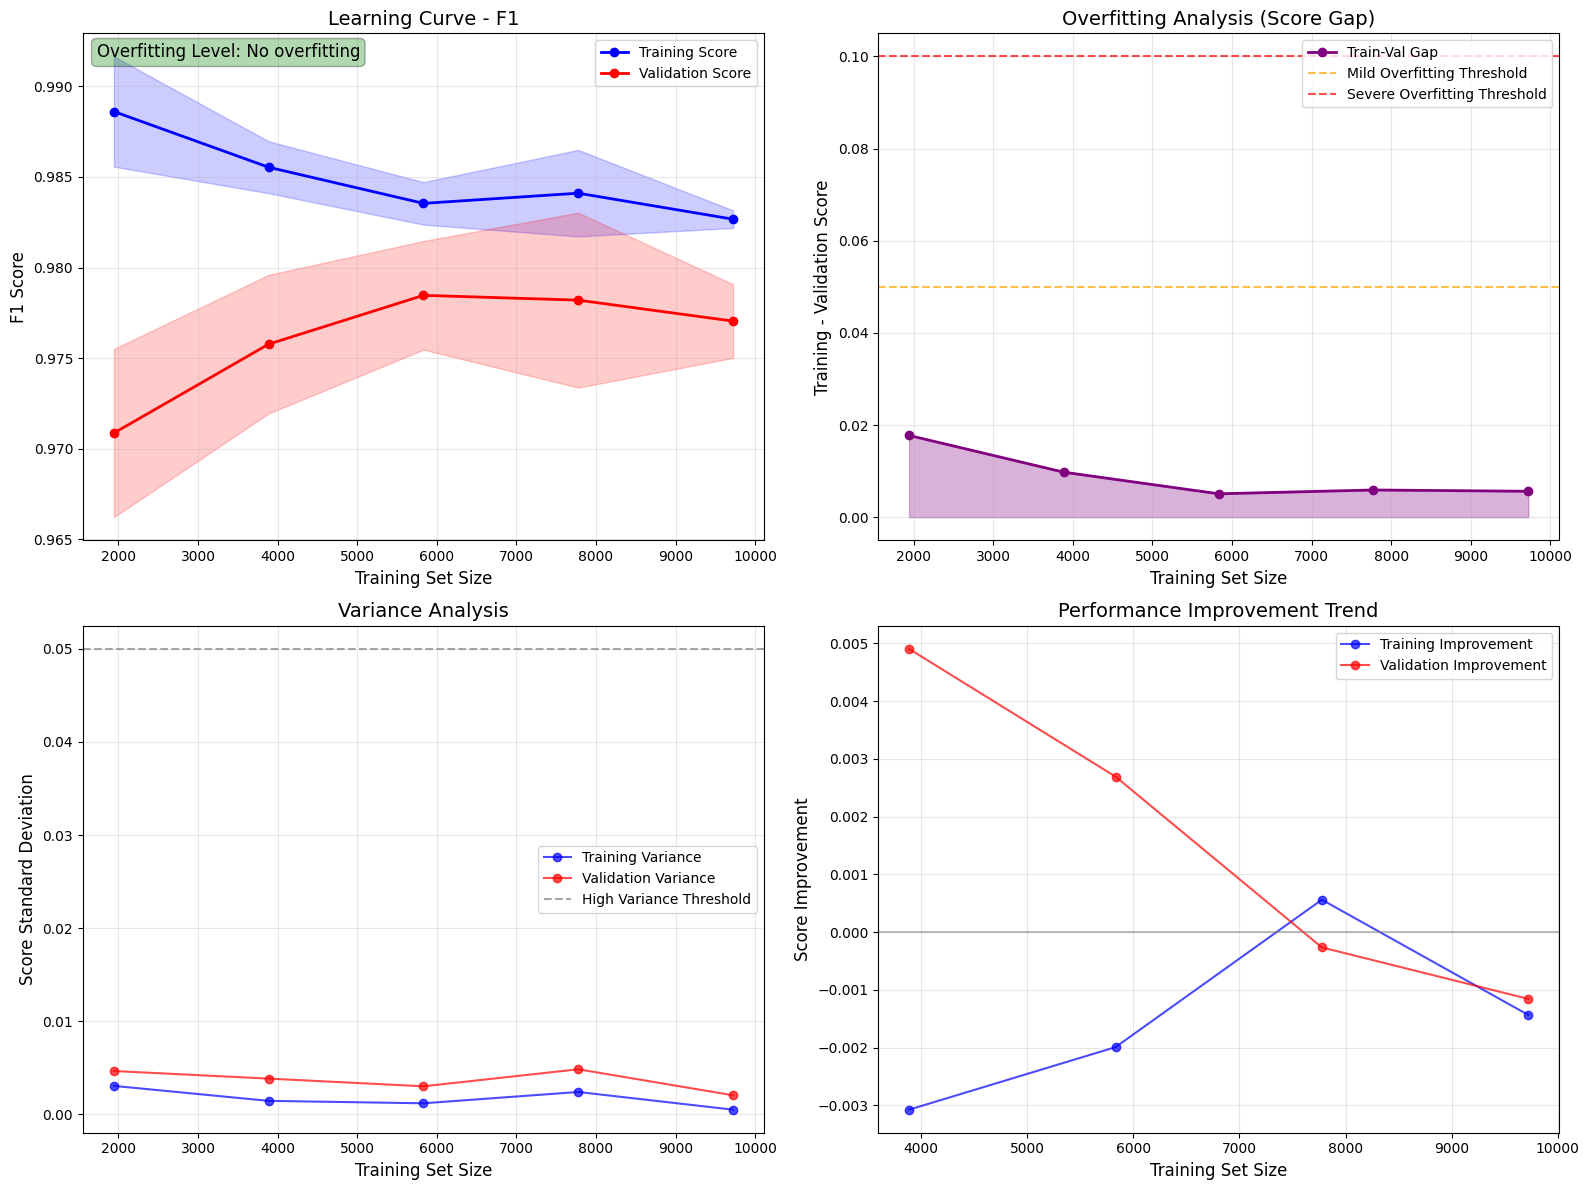


📊 详细学习曲线分析报告

🎯 基本性能指标:
  最终训练分数: 0.9827 (±0.0005)
  最终验证分数: 0.9770 (±0.0020)
  训练-验证差异: 0.0056

🔍 过拟合分析:
  过拟合程度: No overfitting
  最大分数差异: 0.0177
  学习效率: 68.3%

📈 趋势分析:
  ⚠️ 验证性能提升放缓
  📊 验证性能趋于稳定

📊 方差分析:
  训练方差: 0.0017
  验证方差: 0.0037
  ✅ 方差适中，模型相对稳定

💡 优化建议:
  1. 验证性能已饱和，考虑调整模型架构

📋 总结:
  ✅ 模型拟合程度良好
  ✅ 模型方差适中

✅ 增强版学习曲线分析完成！
✅ 学习曲线分析完成
分别预处理三个数据集...
预处理后数据形状:
  训练集: (12153, 23)
  验证集: (4051, 23)
  测试集: (4051, 23)
构建TRANSFORMER模型...
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 2 | Params: 116,701

开始模型训练
模型类型: transformer
训练样本: 12153
验证样本: 4051
批次大小: 256
训练轮数: 50
训练设备: GPU 🚀
  设备: /physical_device:GPU:0

Epoch 1/50


E0000 00:00:1763354719.286532  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


  loss: 1.5986 - accuracy: 0.8126 - val_loss: 1.4855 - val_accuracy: 0.8240 [5.6s]

Epoch 2/50
  loss: 1.1272 - accuracy: 0.9261 - val_loss: 1.2058 - val_accuracy: 0.8393 [5.0s]

Epoch 3/50
  loss: 0.8483 - accuracy: 0.9491 - val_loss: 0.9657 - val_accuracy: 0.8716 [1.6s]

Epoch 4/50
  loss: 0.6514 - accuracy: 0.9561 - val_loss: 0.7677 - val_accuracy: 0.8980 [1.5s]

Epoch 5/50
  loss: 0.5164 - accuracy: 0.9602 - val_loss: 0.6321 - val_accuracy: 0.8993 [1.6s]

Epoch 6/50
  loss: 0.4057 - accuracy: 0.9649 - val_loss: 0.4891 - val_accuracy: 0.9410 [1.5s]

Epoch 7/50
  loss: 0.3297 - accuracy: 0.9686 - val_loss: 0.4726 - val_accuracy: 0.8902 [1.6s]

Epoch 8/50
  loss: 0.2746 - accuracy: 0.9696 - val_loss: 0.3371 - val_accuracy: 0.9467 [1.5s]

Epoch 9/50
  loss: 0.2353 - accuracy: 0.9703 - val_loss: 0.2974 - val_accuracy: 0.9477 [1.4s]

Epoch 10/50
  loss: 0.2030 - accuracy: 0.9711 - val_loss: 0.2213 - val_accuracy: 0.9706 [1.5s]

Epoch 11/50
  loss: 0.1785 - accuracy: 0.9719 - val_loss: 0.

E0000 00:00:1763354804.391731  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


测试集性能: Acc=0.9825 | P=0.9865 | R=0.9795 | F1=0.9830 | AUC=0.9967


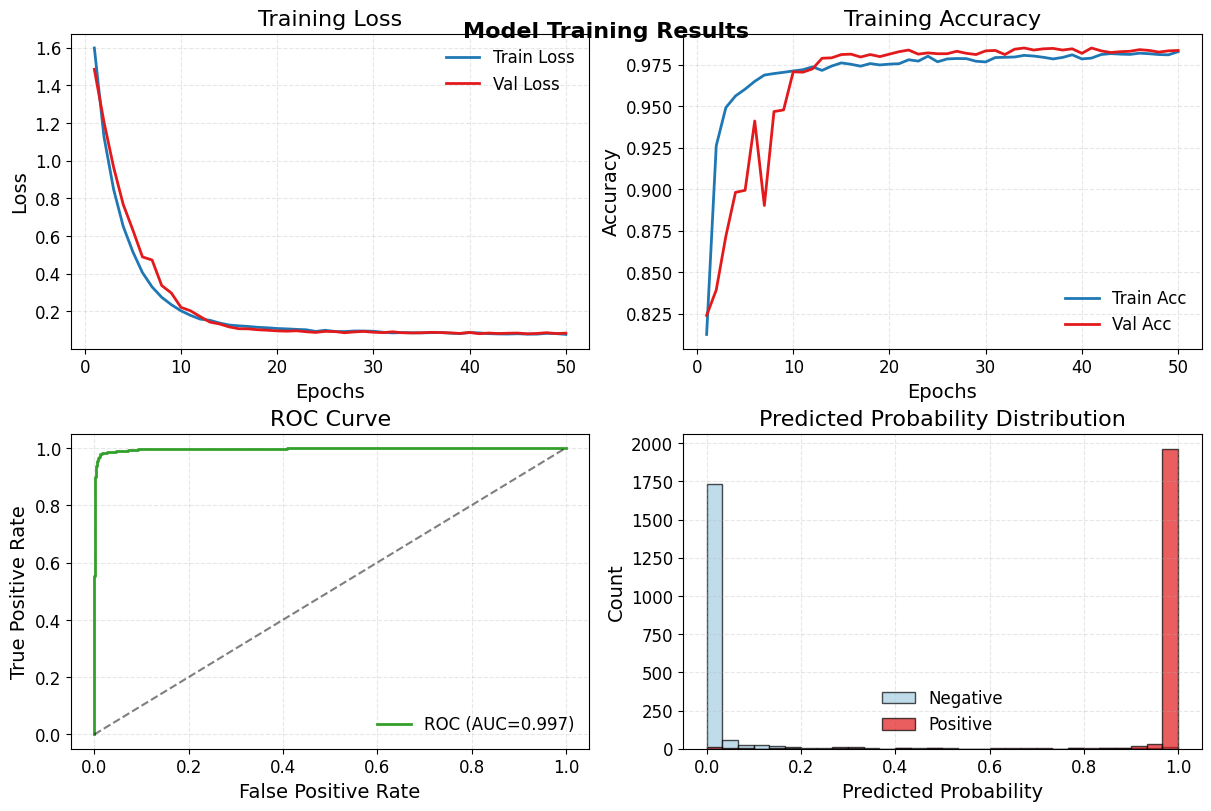

✅ TRANSFORMER 训练完成！

步骤4: 对剩余预测样本进行预测
剩余样本预测完成: 60555 个样本
预测为正类的数量: 52145
预测为正类的比例: 0.861
平均预测概率: 0.854

步骤5: 合并负样本和预测结果

检查GMM评分列:
  negative_results有gmm_score列: True
  prediction_results有gmm_score列: True
  final_results有gmm_score列: True
最终结果合并完成:
  负样本数量: 9782 (标签=0)
  预测样本数量: 60555
  总样本数量: 70337
  最终预测为正类的总数: 52145
  最终预测为正类的比例: 0.741

步骤6: SHAP特征重要性分析
诊断 Transformer 模型


E0000 00:00:1763354816.513712  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



性能指标:
  ACCURACY    : 0.9825
  PRECISION   : 0.9865
  RECALL      : 0.9795
  F1          : 0.9830
  AUC         : 0.9967


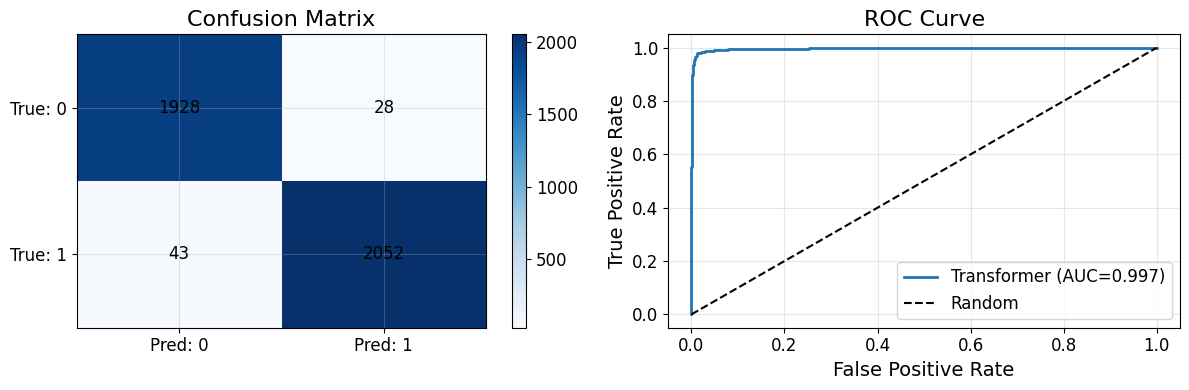


计算SHAP值...


  0%|          | 0/1000 [00:00<?, ?it/s]

E0000 00:00:1763354821.296873  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
E0000 00:00:1763354826.257012  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),

  ✅ SHAP计算完成

步骤6.5: PU学习评估
  估计正样本先验概率（π）: 34.1%
📊 增强PU评估 - 考虑采样偏差和错分类代价:
   - 训练时负样本比例: 1.0 (正样本比例: 50.0%)
   - 测试集正样本: 2095
   - 测试集负样本: 1956
   - 未标注样本: 60555
   - 错分类代价比 (FP:FN): 2.0:1.0
✅ 基于满足约束的PU-F1选择最佳阈值

PU评估摘要

Top 10 阈值结果 (按F1_prime_enhanced):
--------------------------------------------------------------------------------
Thr      R        D        FPR      F1       F1′      Rel     
--------------------------------------------------------------------------------
 0.950  0.947  0.742  0.005  0.970  1.208     High
 0.900  0.961  0.778  0.008  0.976  1.187     High
 0.850  0.965  0.798  0.009  0.978  1.164     High
 0.800  0.968  0.812  0.010  0.979  1.153     High
 0.750  0.970  0.823  0.012  0.980  1.143     High
 0.700  0.973  0.832  0.012  0.981  1.136     High
 0.650  0.977  0.840  0.013  0.982  1.134     High
 0.600  0.979  0.847  0.013  0.983  1.128     High
 0.550  0.979  0.854  0.013  0.983  1.120     High
 0.500  0.979  0.861  0.014  0.983  1.112     High

最佳阈值详情
阈

/tmp/ipykernel_297926/1147384337.py:1105: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


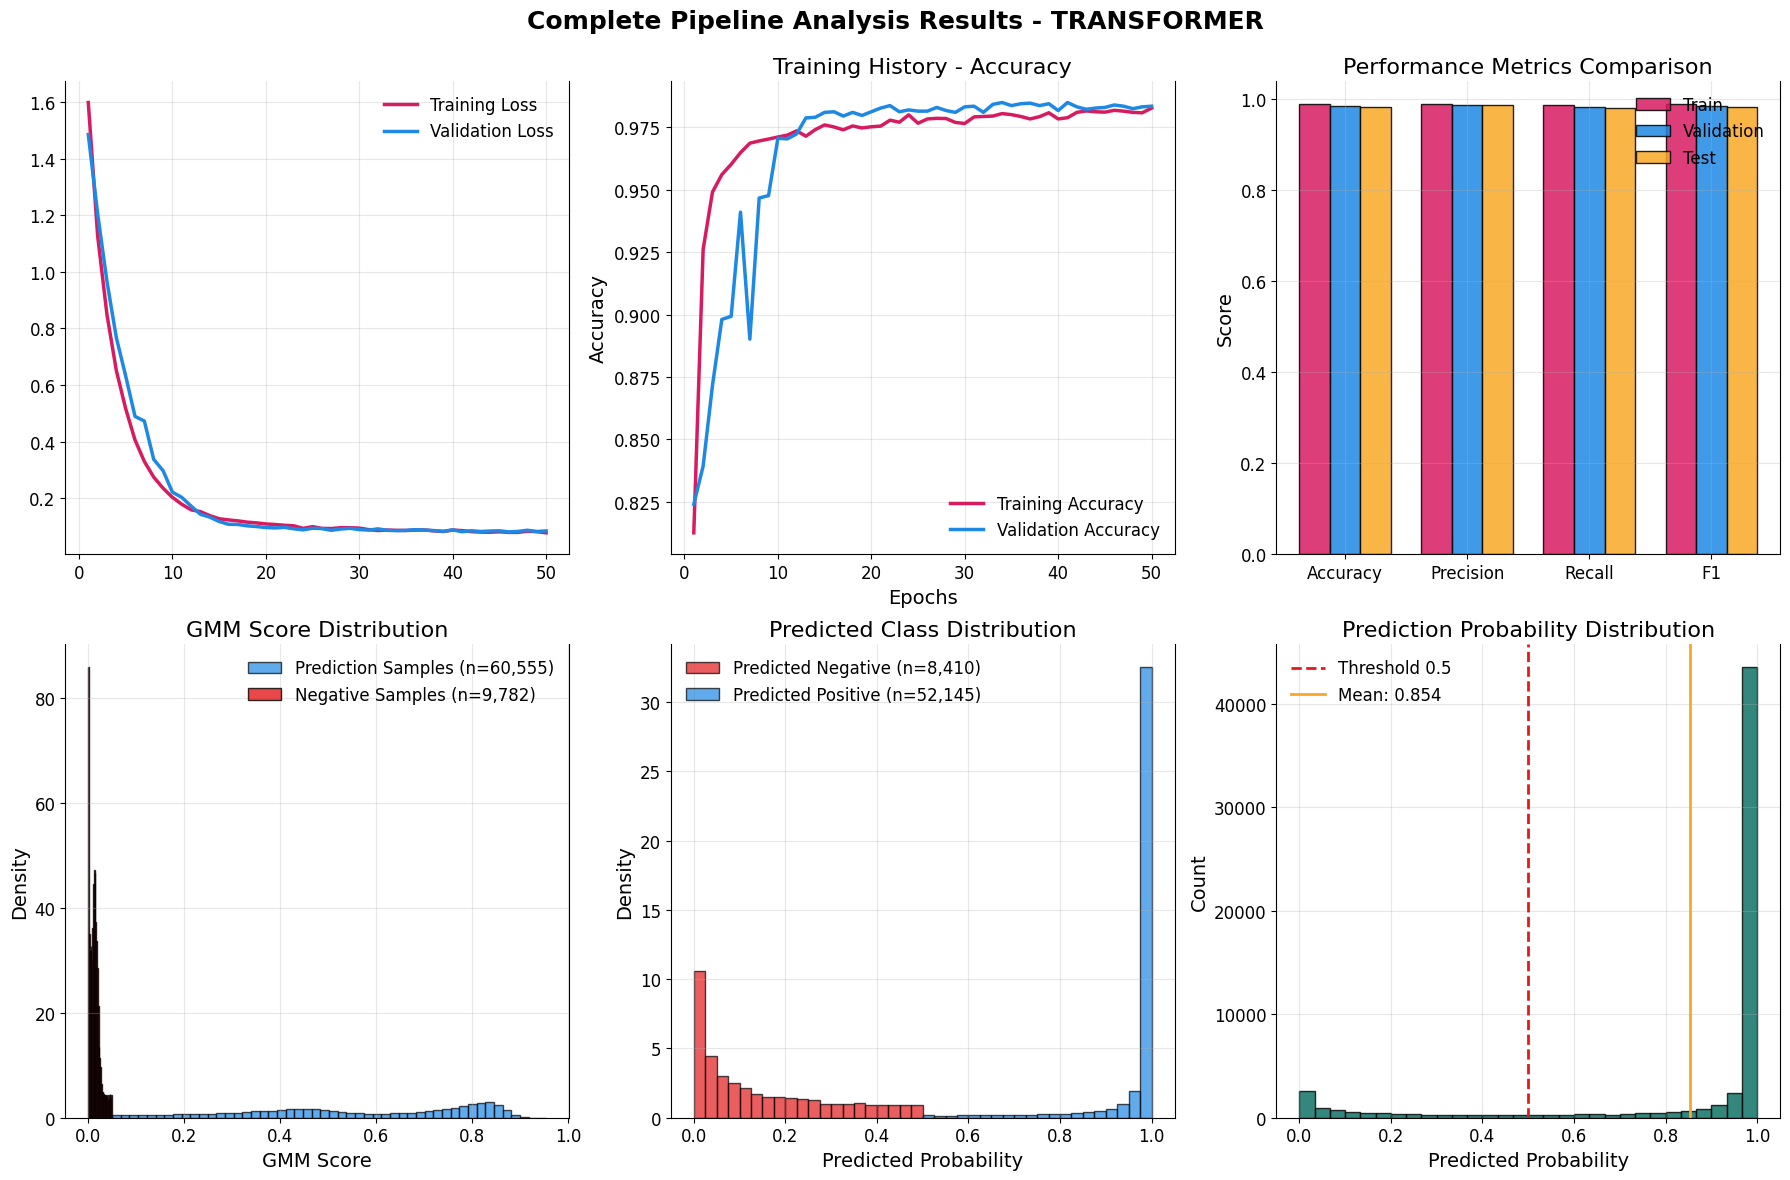


学习曲线分析总结:
✅ 模型拟合程度良好
✅ 模型方差适中
最终性能: 0.9770

✅ 分层负样本采样的训练管道执行完成！

🎯 PU学习评估结果:
   推荐阈值: 0.950
   召回率(R): 0.947
   检测率(D): 0.742
   误报率(FPR): 0.005
   F1′增强: 1.208

💡 建议: ✅ 推荐阈值 0.950 (覆盖率 74.2%，召回率 94.7%)

📊 模型性能:
   测试集AUC: 0.996687995080311


E0000 00:00:1763355472.563572  297926 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


✅ 训练历史已保存到配置文件
✅ 学习曲线分析结果已保存到配置文件
✅ PU评估结果已保存到配置文件

✅ 完整模型保存成功 (版本 3.0):
  - 主文件: data/US_data/ML_model/landuse_transformer_selection_single_20251117_045752.pkl
  - GMM模型: data/US_data/ML_model/landuse_transformer_selection_single_20251117_045752_gmm.pkl
  - 深度学习模型: data/US_data/ML_model/landuse_transformer_selection_single_20251117_045752_dl.h5
  - 预处理器: data/US_data/ML_model/landuse_transformer_selection_single_20251117_045752_preprocessor.pkl
  - 测试数据: data/US_data/ML_model/landuse_transformer_selection_single_20251117_045752_test_data.npz
  - 配置文件: data/US_data/ML_model/landuse_transformer_selection_single_20251117_045752_config.json

📋 模型信息:
  - 学习模型: Transformer
  - 采样策略: Selection-based
  - 训练模式: single
  - 版本标签: transformer_selection_single

📊 保存的数据:
  - 训练历史: ✅
  - 学习曲线: ✅
  - ROC数据: ✅
  - PU评估: ✅
  - 性能指标: ✅

✅ 结果已保存:
  📦 模型管道: data/US_data/ML_model/landuse_transformer_selection_single_20251117_045752.pkl
  📊 预测结果: data/US_data/ML_model/results_transformer_20251117_045752.csv

In [9]:
print("\n" + "="*80)
print("场景1: 选择式采样 + Transformer单模型")
print("="*80)

complete_results = run_correct_training_pipeline(
    df_positive=df_embedding_fill,              # 正样本
    df_prediction_pool=df_abandon_filtered,     # 预测样本池
    features_no_coords=features_no_coords,
    negative_ratio=1,
    sampling_strategy="simple",                   # 分层策略
    difficulty_levels=3,
    test_size=0.2,
    val_size=0.2,
    epochs=50,
    batch_size=256,
    random_state=42,
    hidden_layers=[128, 64, 32],
    dropout_rate=0.3,
    learning_rate=0.001,
    run_shap=True,                              # 启用SHAP分析
    negative_strategy="selection",               # 选择式采样
    train_mode="single",                        # 单模型模式
    model_type="transformer",                   # Transformer模型
    plot_learning_curve=True,
    learning_curve_epochs=30,
    transformer_config={'d_model': 64, 'num_heads': 4, 'num_layers': 2}
)

if complete_results is not None:
    # ============================================================
    # 1. 输出评估结果
    # ============================================================
    if complete_results.get('pu_evaluation'):
        pu_results = complete_results['pu_evaluation']
        print(f"\n🎯 PU学习评估结果:")
        print(f"   推荐阈值: {pu_results['best']['thr']:.3f}")
        print(f"   召回率(R): {pu_results['best']['R']:.3f}")
        print(f"   检测率(D): {pu_results['best']['D']:.3f}")
        print(f"   误报率(FPR): {pu_results['best']['FPR']:.3f}")
        print(f"   F1′增强: {pu_results['best']['F1_prime_enhanced']:.3f}")
        print(f"\n💡 建议: {pu_results['recommendation']}")
    
    # 输出训练评估结果
    if 'training_results' in complete_results:
        test_auc = complete_results['training_results'].get('test_auc', 'N/A')
        print(f"\n📊 模型性能:")
        print(f"   测试集AUC: {test_auc}")
    
    # ============================================================
    # 2. 保存模型和结果
    # ============================================================
    save_dir = "data/US_data/ML_model"
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    saved_model_path = save_complete_model_pipeline(
        gmm_pipeline=complete_results['gmm_pipeline'],
        dl_model=complete_results['model'],  
        features=features_no_coords,
        config=complete_results['config'],
        retrained_preprocessor=complete_results['training_results']['preprocessor'],
        training_results=complete_results['training_results'],
        pu_evaluation=complete_results.get('pu_evaluation'),  # ✅ 传递PU评估结果
        save_dir=save_dir,
        model_name=None
    )

    # ✅ 保存预测结果CSV
    final_results = complete_results['final_results']
    model_type = complete_results['config'].get('model_type', 
                    complete_results['training_results'].get('model_type', 'unknown'))
    output_file = os.path.join(save_dir, f"results_{model_type}_{timestamp}.csv")
    final_results.to_csv(output_file, index=False)

    # ============================================================
    # 3. 可选：保存轻量级摘要文件（仅用于快速查看）
    # ============================================================
    # 注意：完整配置已在 save_complete_model_pipeline 中保存到 {model_name}_config.json
    # 此摘要文件仅用于快速查看关键指标，不包含完整数据
    
    summary_file = os.path.join(save_dir, f"summary_{model_type}_{timestamp}.json")
    with open(summary_file, 'w') as f:
        summary_to_save = {
            'timestamp': timestamp,
            'model_path': saved_model_path,
            'results_path': output_file,
            'model_type': model_type,
            'negative_strategy': complete_results['config'].get('negative_strategy', 'selection'),
            'train_mode': 'single',
            
            # 关键性能指标摘要
            'performance_summary': {
                'test_auc': complete_results['training_results'].get('test_auc'),
                'final_performance': (complete_results.get('learning_curve_analysis') or {}).get('final_performance'),
                'overfitting_detected': (complete_results.get('learning_curve_analysis') or {}).get('overfitting_detected'),
            },
            
            # PU评估摘要（如有）
            'pu_evaluation_summary': {
                'best_threshold': complete_results['pu_evaluation']['best']['thr'],
                'detection_rate': complete_results['pu_evaluation']['best']['D'],
                'recall_rate': complete_results['pu_evaluation']['best']['R'],
                'fpr': complete_results['pu_evaluation']['best']['FPR'],
                'recommendation': complete_results['pu_evaluation']['recommendation']
            } if complete_results.get('pu_evaluation') else None,
            
            # 数据统计摘要
            'data_summary': {
                'total_samples': len(final_results),
                'negative_samples': len(complete_results.get('negative_samples', [])),
                'prediction_samples': len(complete_results.get('prediction_results', [])),
                'predicted_positive': int(final_results['predicted_label'].sum()),
                'positive_ratio': float(final_results['predicted_label'].mean())
            },
            
            # 提示：完整配置请查看主配置文件
            'note': f'完整配置和训练历史请查看: {os.path.basename(saved_model_path).replace(".pkl", "_config.json")}'
        }
        json.dump(summary_to_save, f, indent=2, default=str)

    # ============================================================
    # 4. 输出保存结果
    # ============================================================
    print(f"\n✅ 结果已保存:")
    print(f"  📦 模型管道: {saved_model_path}")
    print(f"  📊 预测结果: {output_file}")
    print(f"  📋 摘要文件: {summary_file}")
    print(f"  ⚙️  完整配置: {os.path.basename(saved_model_path).replace('.pkl', '_config.json')}")
    
    print(f"\n📊 最终统计:")
    print(f"  - 总样本数: {len(final_results):,}")
    print(f"  - 负样本数: {len(complete_results.get('negative_samples', [])):,}")
    print(f"  - 预测样本数: {len(complete_results.get('prediction_results', [])):,}")
    print(f"  - 预测为正类: {final_results['predicted_label'].sum():,}")
    print(f"  - 正类比例: {final_results['predicted_label'].mean():.3%}")
    
else:
    print("❌ 训练管道执行失败")

## 生成式采样

### 生成式采样+Transformer


场景2: 生成式采样 + Transformer单模型
正确的训练管道：分层负样本采样的完整流程

步骤1: 加载或训练GMM模型用于环境相似度评估
[GMM] 当前项目根目录推断为: /mnt/c/Dev/Landuse_Zhong_clean
🔍 发现已保存的GMM模型文件: /mnt/c/Dev/Landuse_Zhong_clean/gmm_model_23c_fixed.pkl
📂 尝试加载模型...
✅ 成功加载GMM模型: gmm_model_23c_fixed.pkl
   模型组件数: 23
   协方差类型: diag

步骤2: 负样本生成 - 策略: generation

统一负样本生成接口 - 策略: generation

生成式负样本策略（纯粹GMM采样）

生成配置:
  正样本数: 10473
  目标负样本数: 10473

筛选标准:
  正样本平均log概率: 49.978
  阈值 (均值 - 1std): 27.508

尝试 1/8: 采样 20946 个...
  实际采样: 20946 个
  符合阈值: 217 个 (1.0%)
  累计有效样本: 217 个
  ⏳ 继续增加采样量 (下次: 31419 个)...

尝试 2/8: 采样 31419 个...
  实际采样: 31419 个
  符合阈值: 359 个 (1.1%)
  累计有效样本: 576 个
  ⏳ 继续增加采样量 (下次: 41892 个)...

尝试 3/8: 采样 41892 个...
  实际采样: 41892 个
  符合阈值: 476 个 (1.1%)
  累计有效样本: 1052 个
  ⏳ 继续增加采样量 (下次: 62838 个)...

尝试 4/8: 采样 62838 个...
  实际采样: 62838 个
  符合阈值: 710 个 (1.1%)
  累计有效样本: 1762 个
  ⏳ 继续增加采样量 (下次: 94257 个)...

尝试 5/8: 采样 94257 个...
  实际采样: 94257 个
  符合阈值: 1070 个 (1.1%)
  累计有效样本: 2832 个
  ⏳ 继续增加采样量 (下次: 136149 个)...

尝试 6/8: 采样 136149 个...
  实际采样

E0000 00:00:1765476900.627379     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
E0000 00:00:1765476947.229125     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),

    Fold 1/5 | train_score=0.917, val_score=0.849
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765476991.568553     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 2/5 | train_score=0.917, val_score=0.850
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477036.255418     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 3/5 | train_score=0.903, val_score=0.851
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477080.681750     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 4/5 | train_score=0.917, val_score=0.839
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477131.378641     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 5/5 | train_score=0.915, val_score=0.840

🔹 训练集大小 4830 / 12075
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477228.413202     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 1/5 | train_score=0.897, val_score=0.861
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477333.226897     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 2/5 | train_score=0.890, val_score=0.855
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477434.777696     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 3/5 | train_score=0.898, val_score=0.856
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477539.393504     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 4/5 | train_score=0.897, val_score=0.858
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477643.561234     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 5/5 | train_score=0.901, val_score=0.856

🔹 训练集大小 7245 / 12075
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477819.066641     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 1/5 | train_score=0.889, val_score=0.863
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765477977.141442     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 2/5 | train_score=0.902, val_score=0.864
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765478138.300343     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 3/5 | train_score=0.894, val_score=0.861
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765478286.999470     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 4/5 | train_score=0.891, val_score=0.863
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765478435.502126     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 5/5 | train_score=0.895, val_score=0.854

🔹 训练集大小 9660 / 12075
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765478645.679432     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 1/5 | train_score=0.887, val_score=0.871
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765478852.141087     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 2/5 | train_score=0.895, val_score=0.878
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765479046.907135     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 3/5 | train_score=0.885, val_score=0.866
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765479251.759568     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 4/5 | train_score=0.902, val_score=0.872
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765479463.938617     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 5/5 | train_score=0.896, val_score=0.862

🔹 训练集大小 12074 / 12075
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765479666.897911     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 1/5 | train_score=0.887, val_score=0.871
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765479883.911601     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 2/5 | train_score=0.895, val_score=0.878
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765480076.419252     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 3/5 | train_score=0.885, val_score=0.866
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765480271.598673     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 4/5 | train_score=0.902, val_score=0.872
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437


E0000 00:00:1765480440.956203     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


    Fold 5/5 | train_score=0.896, val_score=0.862

✅ 学习曲线计算完成
  训练集大小: (5,)
  训练得分形状: (5, 5)
  验证得分形状: (5, 5)
绘制学习曲线


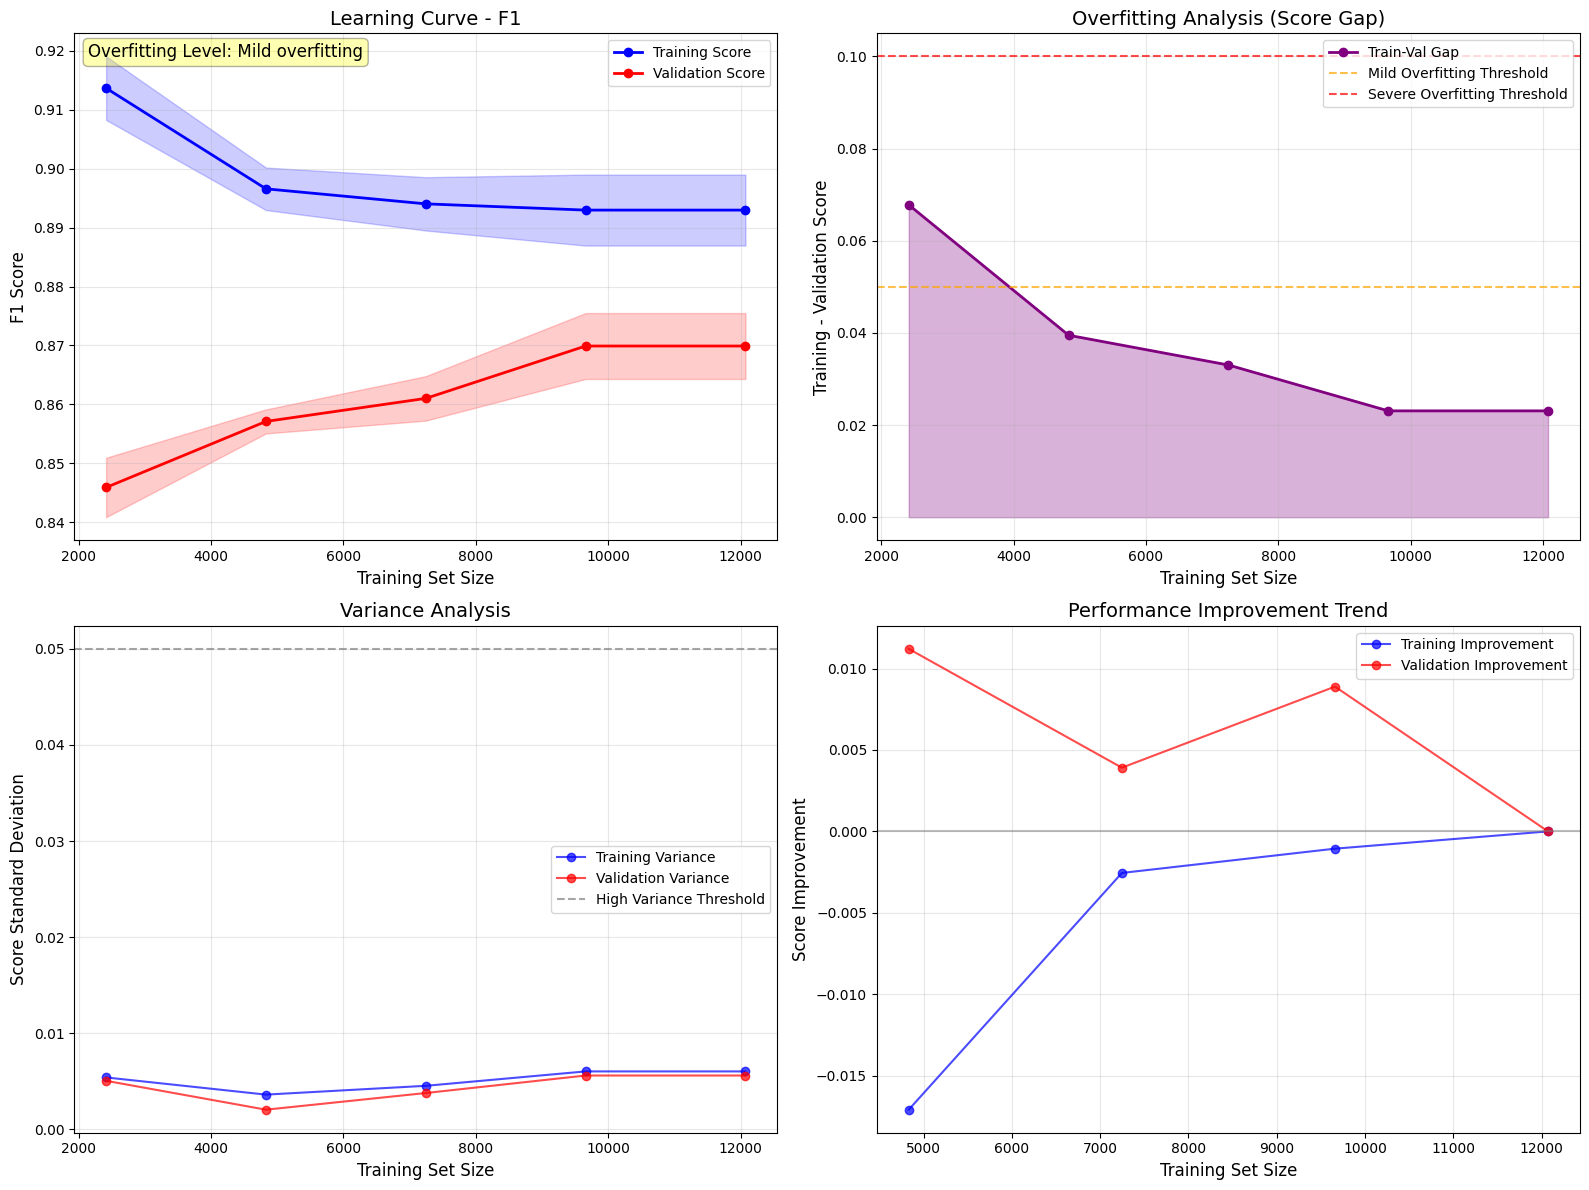


📊 详细学习曲线分析报告

🎯 基本性能指标:
  最终训练分数: 0.8930 (±0.0060)
  最终验证分数: 0.8699 (±0.0056)
  训练-验证差异: 0.0231

🔍 过拟合分析:
  过拟合程度: Mild overfitting
  最大分数差异: 0.0678
  学习效率: 66.0%

📈 趋势分析:
  ✅ 验证性能持续改善
  📊 验证性能趋于稳定

📊 方差分析:
  训练方差: 0.0051
  验证方差: 0.0044
  ✅ 方差适中，模型相对稳定

✅ 模型表现良好，无需特殊调整

📋 总结:
  ✅ 模型拟合程度良好
  ✅ 模型方差适中
保存学习曲线结果
✅ 学习曲线结果准备完成

✅ 增强版学习曲线分析完成！
✅ 学习曲线分析完成
分别预处理三个数据集...
预处理后数据形状:
  训练集: (12075, 23)
  验证集: (4026, 23)
  测试集: (4026, 23)
构建TRANSFORMER模型...
Building Transformer+ResNet Hybrid Model...
  Input dim: 23 | Transformer layers: 4 | Params: 97,437

开始模型训练
模型类型: transformer
训练样本: 12075
验证样本: 4026
批次大小: 256
训练轮数: 80
训练设备: GPU 🚀
  设备: /physical_device:GPU:0
Epoch 1/80


E0000 00:00:1765480452.212885     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


48/48 - 9s - 194ms/step - accuracy: 0.7207 - auc: 0.7955 - loss: 0.5893 - precision: 0.7199 - recall: 0.7582 - val_accuracy: 0.7717 - val_auc: 0.8655 - val_loss: 0.4927 - val_precision: 0.8128 - val_recall: 0.7294
Epoch 2/80
48/48 - 2s - 46ms/step - accuracy: 0.7900 - auc: 0.8738 - loss: 0.4784 - precision: 0.7827 - recall: 0.8256 - val_accuracy: 0.8105 - val_auc: 0.8973 - val_loss: 0.4574 - val_precision: 0.8252 - val_recall: 0.8067
Epoch 3/80
48/48 - 2s - 42ms/step - accuracy: 0.8070 - auc: 0.8901 - loss: 0.4524 - precision: 0.8019 - recall: 0.8356 - val_accuracy: 0.8294 - val_auc: 0.9123 - val_loss: 0.4275 - val_precision: 0.8372 - val_recall: 0.8344
Epoch 4/80
48/48 - 2s - 42ms/step - accuracy: 0.8171 - auc: 0.8979 - loss: 0.4377 - precision: 0.8148 - recall: 0.8391 - val_accuracy: 0.8376 - val_auc: 0.9232 - val_loss: 0.4029 - val_precision: 0.8384 - val_recall: 0.8520
Epoch 5/80
48/48 - 2s - 45ms/step - accuracy: 0.8245 - auc: 0.9042 - loss: 0.4249 - precision: 0.8224 - recall: 0.

E0000 00:00:1765480616.261053     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


测试集性能: Acc=0.9131 | P=0.9173 | R=0.9155 | F1=0.9164 | AUC=0.9695


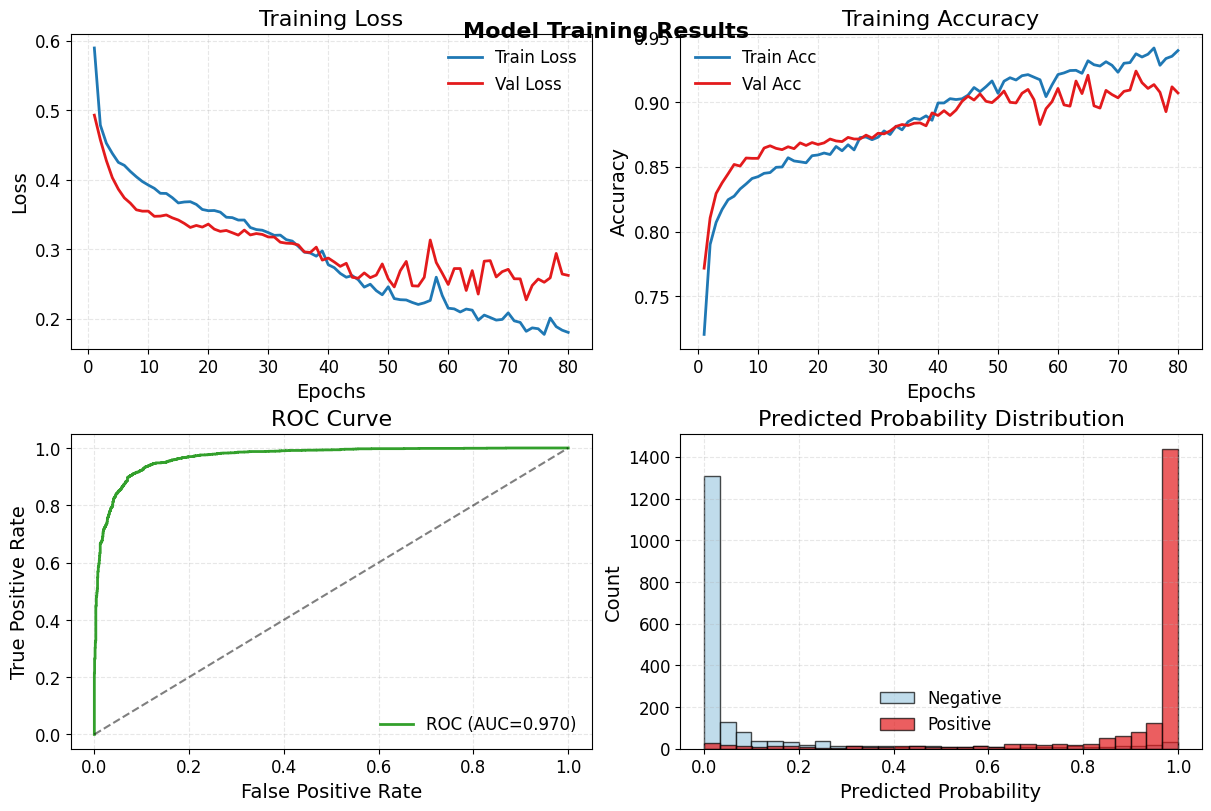

✅ TRANSFORMER 训练完成！

步骤4: 对剩余预测样本进行预测


E0000 00:00:1765480621.489302     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


剩余样本预测完成: 70337 个样本
预测为正类的数量: 58533
预测为正类的比例: 0.832
平均预测概率: 0.822

步骤5: 合并负样本和预测结果
最终结果合并完成:
  负样本数量: 9654 (标签=0)
  预测样本数量: 70337
  总样本数量: 79991
  最终预测为正类的总数: 58533
  最终预测为正类的比例: 0.732

步骤6: SHAP特征重要性分析
诊断 Transformer 模型


E0000 00:00:1765480633.637789     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



性能指标:
  ACCURACY    : 0.9131
  PRECISION   : 0.9173
  RECALL      : 0.9155
  F1          : 0.9164
  AUC         : 0.9695


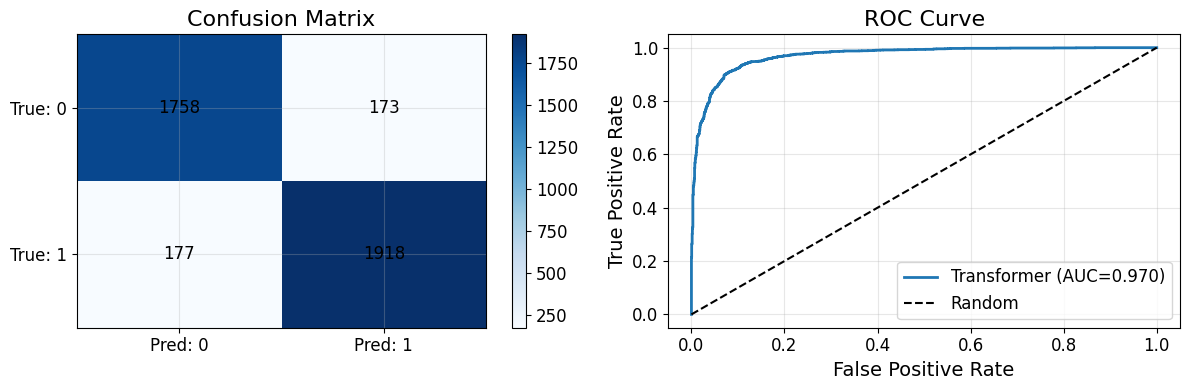


计算SHAP值...


  0%|          | 0/1000 [00:00<?, ?it/s]

E0000 00:00:1765480639.300020     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
E0000 00:00:1765480645.008484     660 node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),

  ✅ SHAP计算完成

步骤6.5: PU学习评估
  估计正样本先验概率（π）: 30.0%
📊 增强PU评估 - 考虑采样偏差和错分类代价:
   - 训练时负样本比例: 1.0 (正样本比例: 50.0%)
   - 测试集正样本: 2095
   - 测试集负样本: 1931
   - 未标注样本: 70337
   - 错分类代价比 (FP:FN): 2.0:1.0
✅ 基于满足约束的PU-F1选择最佳阈值

PU评估摘要

Top 10 阈值结果 (按F1_prime_enhanced):
--------------------------------------------------------------------------------
Thr      R        D        FPR      F1       F1′      Rel     
--------------------------------------------------------------------------------
 0.300  0.946  0.869  0.126  0.917  1.015     High
 0.350  0.939  0.860  0.115  0.918  1.012     High
 0.400  0.933  0.851  0.107  0.918  1.011     High
 0.150  0.966  0.906  0.186  0.904  1.009     High
 0.250  0.949  0.880  0.143  0.912  1.007     High
 0.200  0.955  0.892  0.161  0.908  1.005     High
 0.100  0.972  0.923  0.213  0.897  1.001     High
 0.450  0.922  0.842  0.099  0.916  0.999     High
 0.500  0.916  0.832  0.090  0.916  0.996     High
 0.550  0.910  0.823  0.082  0.916  0.996     High

最佳阈值详情
阈

/mnt/c/Dev/Landuse_Zhong_clean/function/evaluation.py:222: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 0].legend(frameon=False)
/mnt/c/Dev/Landuse_Zhong_clean/function/evaluation.py:271: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


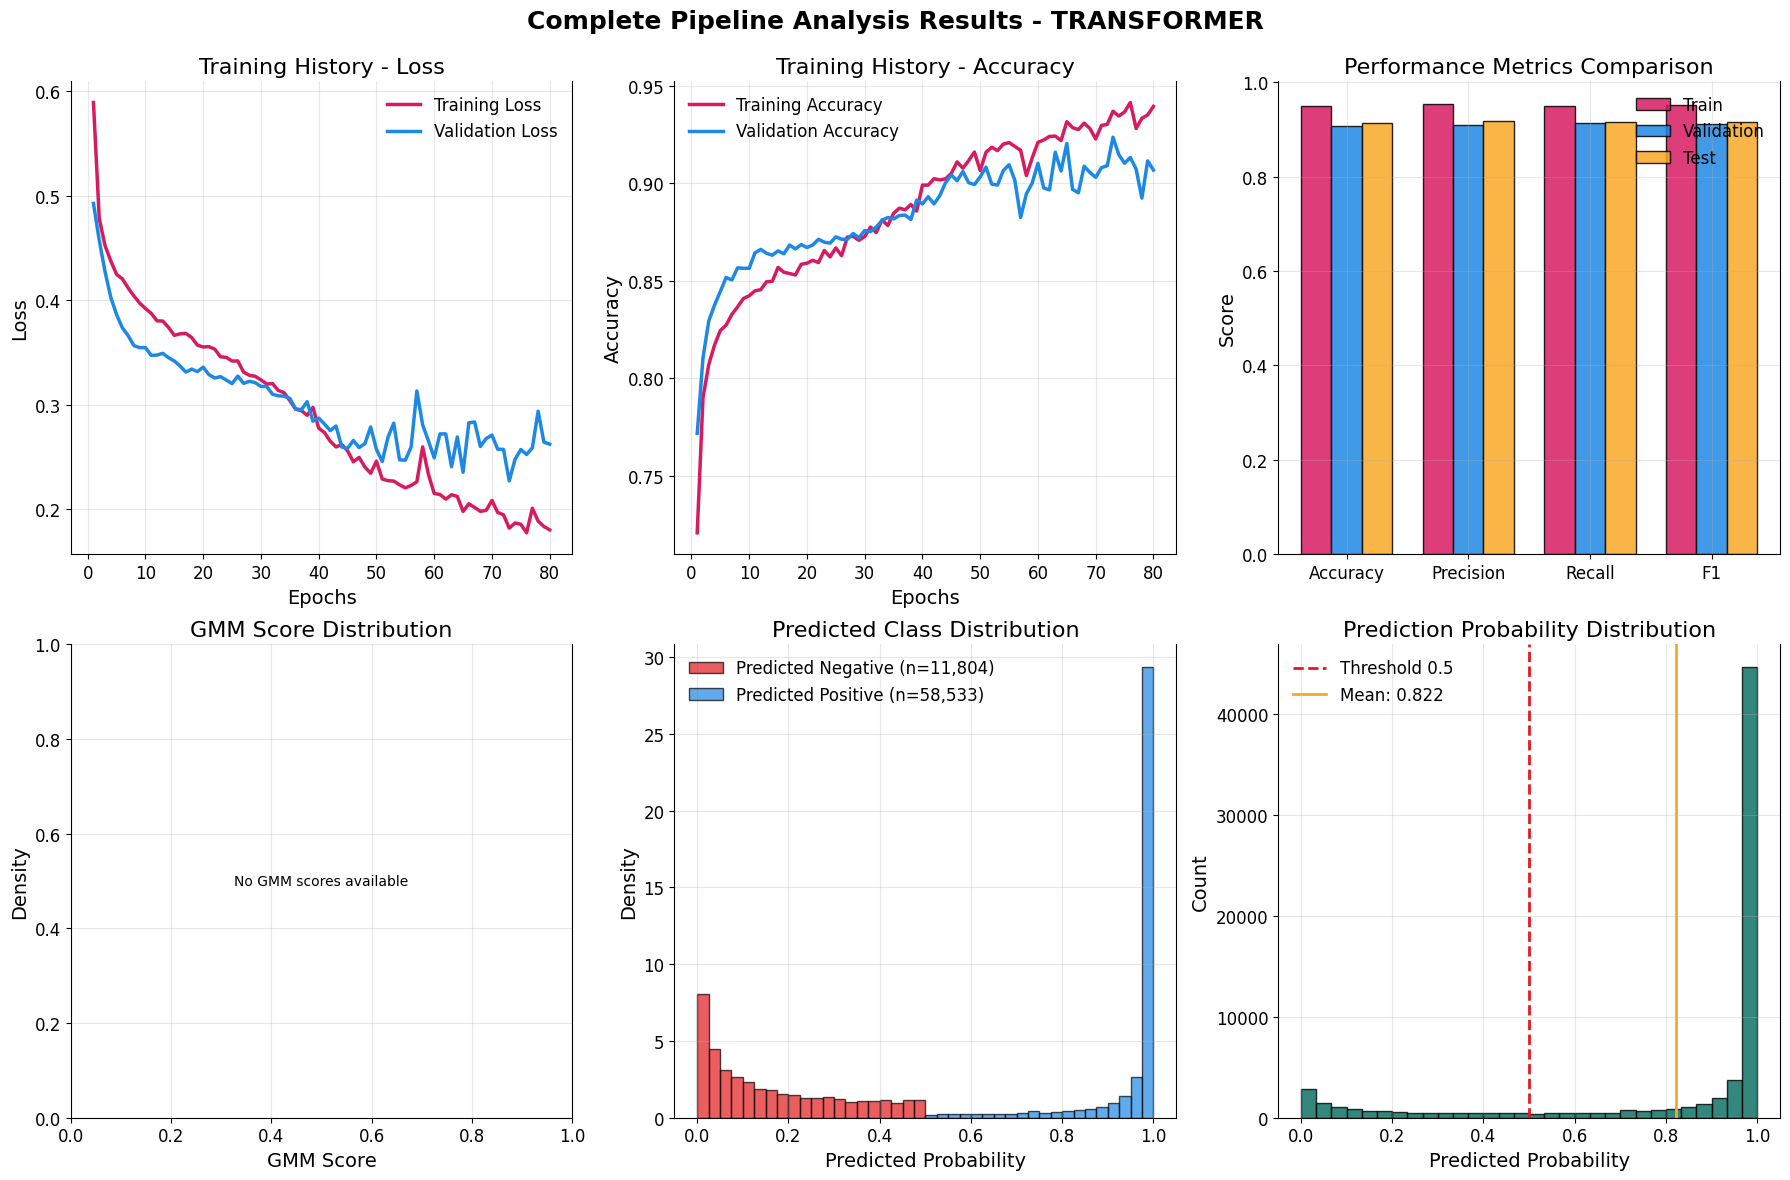


学习曲线分析总结:
✅ 模型拟合程度良好
✅ 模型方差适中
最终性能: 0.8699

✅ 分层负样本采样的训练管道执行完成！

🎯 PU学习评估结果:
   推荐阈值: 0.400
   召回率(R): 0.933
   检测率(D): 0.851
   误报率(FPR): 0.107
   F1′增强: 1.011

💡 建议: ✅ 推荐阈值 0.400 (覆盖率 85.1%，召回率 93.3%)

📊 模型性能:
   测试集AUC: 0.9695463663453588
✅ GMM Pipeline 已保存: data/US_data/ML_model/landuse_transformer_generation_single_20251211_193243_gmm.pkl
✅ 深度学习模型已保存: data/US_data/ML_model/landuse_transformer_generation_single_20251211_193243_dl.h5
✅ 预处理器已保存: data/US_data/ML_model/landuse_transformer_generation_single_20251211_193243_preprocessor.pkl
✅ 训练历史已保存到配置文件
✅ 学习曲线分析结果已保存到配置文件
✅ PU评估结果已保存到配置文件

✅ 完整模型保存成功 (版本 3.0):
  - 主文件: data/US_data/ML_model/landuse_transformer_generation_single_20251211_193243.pkl
  - GMM模型: data/US_data/ML_model/landuse_transformer_generation_single_20251211_193243_gmm.pkl
  - 深度学习模型: data/US_data/ML_model/landuse_transformer_generation_single_20251211_193243_dl.h5
  - 预处理器: data/US_data/ML_model/landuse_transformer_generation_single_20251211_193243_preprocessor.pkl


In [3]:
%matplotlib inline

print("\n" + "="*80)
print("场景2: 生成式采样 + Transformer单模型")
print("="*80)

complete_results_2 = run_correct_training_pipeline(
    df_positive=df_embedding_fill,
    df_prediction_pool=df_abandon_filtered,
    features_no_coords=features_no_coords,
    negative_ratio=1,
    test_size=0.2, val_size=0.2,
    epochs=80, batch_size=256, random_state=42,
    dropout_rate=0.3, learning_rate=0.001,
    resnet_layers=[128]*3,  
    run_shap=True,
    negative_strategy="generation",
    augmentation_ratio=1,
    train_mode="single",
    model_type="transformer",
    plot_learning_curve=True,
    transformer_config = {
        "d_model": 32,
        "num_heads": 2,
        "num_layers": 4,      
    }
)


if complete_results_2 is not None:
    # ============================================================
    # 1. 输出评估结果
    # ============================================================
    if complete_results_2.get('pu_evaluation'):
        pu_results = complete_results_2['pu_evaluation']
        print(f"\n🎯 PU学习评估结果:")
        print(f"   推荐阈值: {pu_results['best']['thr']:.3f}")
        print(f"   召回率(R): {pu_results['best']['R']:.3f}")
        print(f"   检测率(D): {pu_results['best']['D']:.3f}")
        print(f"   误报率(FPR): {pu_results['best']['FPR']:.3f}")
        print(f"   F1′增强: {pu_results['best']['F1_prime_enhanced']:.3f}")
        print(f"\n💡 建议: {pu_results['recommendation']}")
    
    # 输出训练评估结果
    if 'training_results' in complete_results_2:
        test_auc = complete_results_2['training_results'].get('test_auc', 'N/A')
        print(f"\n📊 模型性能:")
        print(f"   测试集AUC: {test_auc}")
    
    # ============================================================
    # 2. 保存模型和结果
    # ============================================================
    save_dir = "data/US_data/ML_model"
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # ✅ 保存完整模型管道（包含所有配置、训练历史、学习曲线等）
    saved_model_path = save_complete_model_pipeline(
        gmm_pipeline=complete_results_2['gmm_pipeline'],
        dl_model=complete_results_2['model'],
        retrained_preprocessor=complete_results_2['training_results']['preprocessor'],
        training_results=complete_results_2['training_results'],
        final_results=complete_results_2.get('final_results'),
        negative_results=complete_results_2.get('negative_samples'),
        prediction_results=complete_results_2.get('prediction_results'),
        features=features_no_coords,
        config=complete_results_2['config'],
        save_dir=save_dir,
        model_name=None,
        model_type=complete_results_2['config'].get('model_type', 'transformer'),
        negative_strategy=complete_results_2['config'].get('negative_strategy', 'generation'),  
        train_mode='single',
        pu_evaluation=complete_results_2.get('pu_evaluation')
    )

    # ✅ 保存预测结果CSV
    final_results = complete_results_2['final_results']
    model_type = complete_results_2['config'].get('model_type', 
                    complete_results_2['training_results'].get('model_type', 'unknown'))
    output_file = os.path.join(save_dir, f"results_{model_type}_{timestamp}.csv")
    final_results.to_csv(output_file, index=False)

    # ============================================================
    # 3. 可选：保存轻量级摘要文件（仅用于快速查看）
    # ============================================================
    # 注意：完整配置已在 save_complete_model_pipeline 中保存到 {model_name}_config.json
    # 此摘要文件仅用于快速查看关键指标，不包含完整数据
    
    summary_file = os.path.join(save_dir, f"summary_{model_type}_{timestamp}.json")
    with open(summary_file, 'w') as f:
        summary_to_save = {
            'timestamp': timestamp,
            'model_path': saved_model_path,
            'results_path': output_file,
            'model_type': model_type,
            'negative_strategy': complete_results_2['config'].get('negative_strategy', 'generation'),
            'train_mode': 'single',
            
            # 关键性能指标摘要
            'performance_summary': {
                'test_auc': complete_results_2['training_results'].get('test_auc'),
                'final_performance': complete_results_2.get('learning_curve_analysis', {}).get('final_performance'),
                'overfitting_detected': complete_results_2.get('learning_curve_analysis', {}).get('overfitting_detected'),
            },
            
            # PU评估摘要（如有）
            'pu_evaluation_summary': {
                'best_threshold': complete_results_2['pu_evaluation']['best']['thr'],
                'detection_rate': complete_results_2['pu_evaluation']['best']['D'],
                'recall_rate': complete_results_2['pu_evaluation']['best']['R'],
                'fpr': complete_results_2['pu_evaluation']['best']['FPR'],
                'recommendation': complete_results_2['pu_evaluation']['recommendation']
            } if complete_results_2.get('pu_evaluation') else None,
            
            # 数据统计摘要
            'data_summary': {
                'total_samples': len(final_results),
                'negative_samples': len(complete_results_2.get('negative_samples', [])),
                'prediction_samples': len(complete_results_2.get('prediction_results', [])),
                'predicted_positive': int(final_results['predicted_label'].sum()),
                'positive_ratio': float(final_results['predicted_label'].mean())
            },
            
            # 提示：完整配置请查看主配置文件
            'note': f'完整配置和训练历史请查看: {os.path.basename(saved_model_path).replace(".pkl", "_config.json")}'
        }
        json.dump(summary_to_save, f, indent=2, default=str)

    # ============================================================
    # 4. 输出保存结果
    # ============================================================
    print(f"\n✅ 结果已保存:")
    print(f"  📦 模型管道: {saved_model_path}")
    print(f"  📊 预测结果: {output_file}")
    print(f"  📋 摘要文件: {summary_file}")
    print(f"  ⚙️  完整配置: {os.path.basename(saved_model_path).replace('.pkl', '_config.json')}")
    
    print(f"\n📊 最终统计:")
    print(f"  - 总样本数: {len(final_results):,}")
    print(f"  - 负样本数: {len(complete_results_2.get('negative_samples', [])):,}")
    print(f"  - 预测样本数: {len(complete_results_2.get('prediction_results', [])):,}")
    print(f"  - 预测为正类: {final_results['predicted_label'].sum():,}")
    print(f"  - 正类比例: {final_results['predicted_label'].mean():.3%}")
    
else:
    print("❌ 训练管道执行失败")

### 生成式采样+RF


场景5: 生成式采样 + RF单模型
正确的训练管道：分层负样本采样的完整流程

步骤1: 加载或训练GMM模型用于环境相似度评估
[GMM] 当前项目根目录推断为: /mnt/c/Dev/Landuse_Zhong_clean
🔍 发现已保存的GMM模型文件: /mnt/c/Dev/Landuse_Zhong_clean/gmm_model_23c_fixed.pkl
📂 尝试加载模型...
✅ 成功加载GMM模型: gmm_model_23c_fixed.pkl
   模型组件数: 23
   协方差类型: diag

步骤2: 负样本生成 - 策略: generation

统一负样本生成接口 - 策略: generation

生成式负样本策略（纯粹GMM采样）

生成配置:
  正样本数: 10473
  目标负样本数: 10473

筛选标准:
  正样本平均log概率: 49.978
  阈值 (均值 - 1std): 27.508

尝试 1/8: 采样 20946 个...
  实际采样: 20946 个
  符合阈值: 217 个 (1.0%)
  累计有效样本: 217 个
  ⏳ 继续增加采样量 (下次: 31419 个)...

尝试 2/8: 采样 31419 个...
  实际采样: 31419 个
  符合阈值: 359 个 (1.1%)
  累计有效样本: 576 个
  ⏳ 继续增加采样量 (下次: 41892 个)...

尝试 3/8: 采样 41892 个...
  实际采样: 41892 个
  符合阈值: 476 个 (1.1%)
  累计有效样本: 1052 个
  ⏳ 继续增加采样量 (下次: 62838 个)...

尝试 4/8: 采样 62838 个...
  实际采样: 62838 个
  符合阈值: 710 个 (1.1%)
  累计有效样本: 1762 个
  ⏳ 继续增加采样量 (下次: 94257 个)...

尝试 5/8: 采样 94257 个...
  实际采样: 94257 个
  符合阈值: 1070 个 (1.1%)
  累计有效样本: 2832 个
  ⏳ 继续增加采样量 (下次: 136149 个)...

尝试 6/8: 采样 136149 个...
  实际采样: 136149 

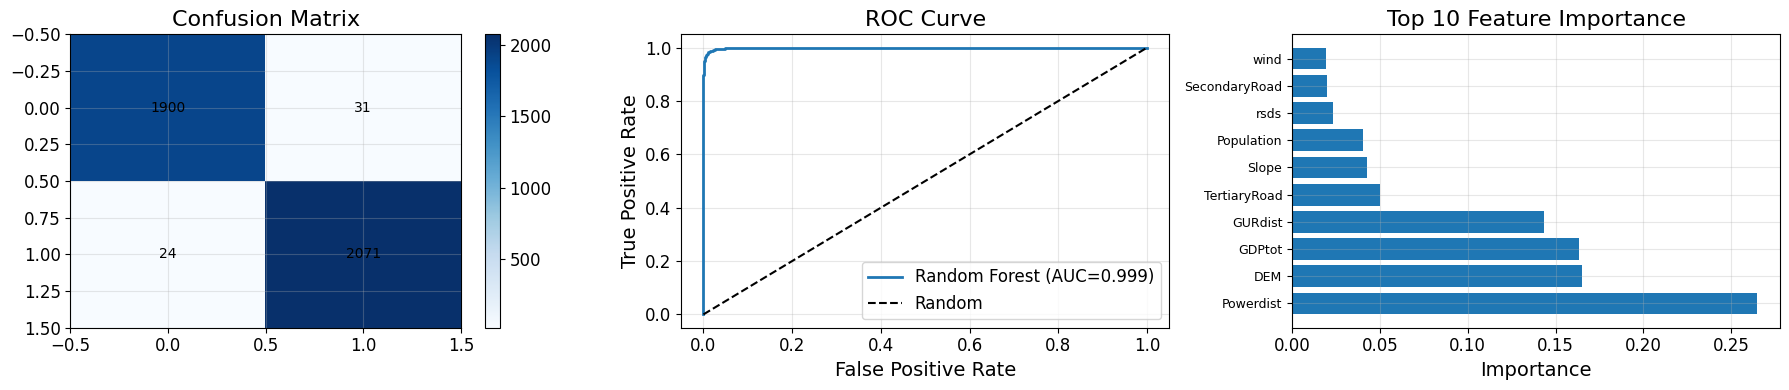


计算SHAP值...
  ✅ SHAP计算完成

预测统计:
  测试样本数: 4026
  预测概率均值: 0.5215 ± 0.4282
  预测概率范围: [0.0000, 0.9992]
  预测为正类数: 2102 (52.21%)
  预测为负类数: 1924

步骤6.5: PU学习评估
  估计正样本先验概率（π）: 30.0%
📊 增强PU评估 - 考虑采样偏差和错分类代价:
   - 训练时负样本比例: 1.0 (正样本比例: 50.0%)
   - 测试集正样本: 2095
   - 测试集负样本: 1931
   - 未标注样本: 70337
   - 错分类代价比 (FP:FN): 2.0:1.0
✅ 基于满足约束的PU-F1选择最佳阈值

PU评估摘要

Top 10 阈值结果 (按F1_prime_enhanced):
--------------------------------------------------------------------------------
Thr      R        D        FPR      F1       F1′      Rel     
--------------------------------------------------------------------------------
 0.700  0.946  0.885  0.002  0.971  1.011     High
 0.650  0.960  0.914  0.004  0.978  1.007     High
 0.400  0.996  0.987  0.032  0.983  1.001     High
 0.500  0.989  0.976  0.016  0.987  0.999     High
 0.600  0.970  0.941  0.006  0.982  0.999     High
 0.350  0.997  0.991  0.051  0.976  0.998     High
 0.750  0.925  0.856  0.001  0.961  0.998     High
 0.450  0.991  0.983  0.023  0.985  0

/mnt/c/Dev/Landuse_Zhong_clean/function/evaluation.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 0].legend(frameon=False)
/mnt/c/Dev/Landuse_Zhong_clean/function/evaluation.py:228: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


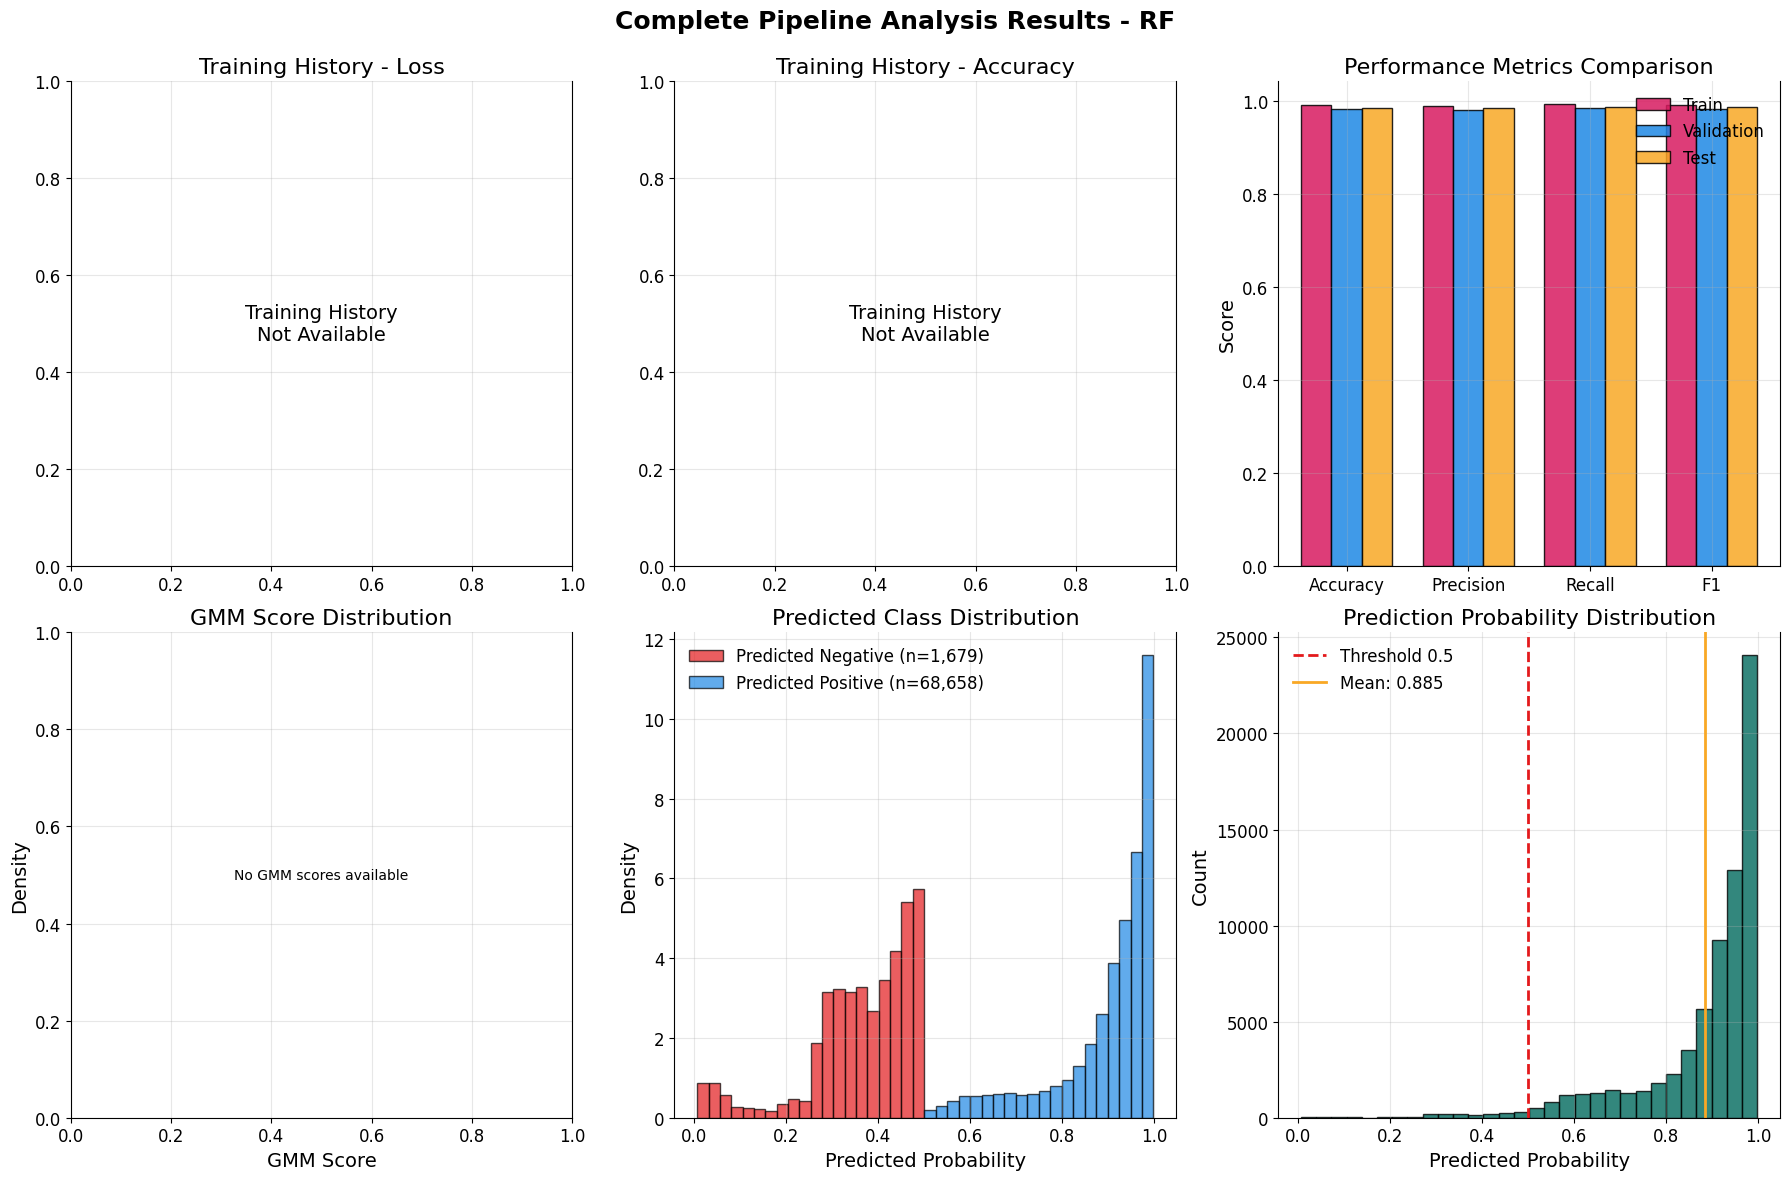


✅ 分层负样本采样的训练管道执行完成！

🎯 PU学习评估结果:
   推荐阈值: 0.900
   召回率(R): 0.768
   检测率(D): 0.653
   误报率(FPR): 0.000
   F1′增强: 0.904

💡 建议: ✅ 推荐阈值 0.900 (覆盖率 65.3%，召回率 76.8%)

📊 模型性能:
   测试集AUC: 0.9988559973006679
✅ 训练历史已保存到配置文件
✅ PU评估结果已保存到配置文件

✅ 完整模型保存成功 (版本 3.0):
  - 主文件: data/US_data/ML_model/landuse_rf_generation_single_20251124_212051.pkl
  - GMM模型: data/US_data/ML_model/landuse_rf_generation_single_20251124_212051_gmm.pkl
  - 深度学习模型: data/US_data/ML_model/landuse_rf_generation_single_20251124_212051_dl.h5
  - 预处理器: data/US_data/ML_model/landuse_rf_generation_single_20251124_212051_preprocessor.pkl
  - 测试数据: data/US_data/ML_model/landuse_rf_generation_single_20251124_212051_test_data.npz
  - 配置文件: data/US_data/ML_model/landuse_rf_generation_single_20251124_212051_config.json

📋 模型信息:
  - 学习模型: Rf
  - 采样策略: Generation-based
  - 训练模式: single
  - 版本标签: rf_generation_single

📊 保存的数据:
  - 训练历史: ✅
  - 学习曲线: ❌
  - ROC数据: ✅
  - PU评估: ✅
  - 性能指标: ✅

✅ 结果已保存:
  📦 模型管道: data/US_data/ML_model/landuse_rf_g

In [5]:
print("\n" + "="*80)
print("场景5: 生成式采样 + RF单模型")
print("="*80)
complete_results_5 = run_correct_training_pipeline(
    df_positive=df_embedding_fill,
    df_prediction_pool=df_abandon_filtered,
    features_no_coords=features_no_coords,
    negative_ratio=1,
    test_size=0.2, val_size=0.2,
    epochs=50, batch_size=256, random_state=42,
    dropout_rate=0.3, learning_rate=0.001,
    run_shap=True,
    negative_strategy="generation",
    augmentation_ratio=0.3,
    train_mode="single",
    model_type="rf",
    plot_learning_curve=True
)

if complete_results_5 is not None:
    # ============================================================
    # 1. 输出评估结果
    # ============================================================
    if complete_results_5.get('pu_evaluation'):
        pu_results = complete_results_5['pu_evaluation']
        print(f"\n🎯 PU学习评估结果:")
        print(f"   推荐阈值: {pu_results['best']['thr']:.3f}")
        print(f"   召回率(R): {pu_results['best']['R']:.3f}")
        print(f"   检测率(D): {pu_results['best']['D']:.3f}")
        print(f"   误报率(FPR): {pu_results['best']['FPR']:.3f}")
        print(f"   F1′增强: {pu_results['best']['F1_prime_enhanced']:.3f}")
        print(f"\n💡 建议: {pu_results['recommendation']}")
    
    if 'training_results' in complete_results_5:
        test_auc = complete_results_5['training_results'].get('test_auc', 'N/A')
        print(f"\n📊 模型性能:")
        print(f"   测试集AUC: {test_auc}")
    
    # ============================================================
    # 2. 保存模型和结果
    # ============================================================
    save_dir = "data/US_data/ML_model"
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    saved_model_path = save_complete_model_pipeline(
        gmm_pipeline=complete_results_5['gmm_pipeline'],
        dl_model=complete_results_5['model'],
        retrained_preprocessor=complete_results_5['training_results']['preprocessor'],
        training_results=complete_results_5['training_results'],
        final_results=complete_results_5.get('final_results'),  
        negative_results=complete_results_5.get('negative_samples'),  
        prediction_results=complete_results_5.get('prediction_results'),  
        features=features_no_coords,
        config=complete_results_5['config'],
        save_dir=save_dir,
        model_name=None,
        model_type=complete_results_5['config'].get('model_type', 'rf'),  
        negative_strategy=complete_results_5['config'].get('negative_strategy', 'generation'),  
        train_mode='single',  
        pu_evaluation=complete_results_5.get('pu_evaluation') 
    )

    final_results = complete_results_5['final_results']
    model_type = complete_results_5['config'].get('model_type', 
                    complete_results_5['training_results'].get('model_type', 'unknown'))
    output_file = os.path.join(save_dir, f"results_{model_type}_{timestamp}.csv")

    if model_type == 'rf':
        rf_export_cols = []
        for col_opt in [
            ['lat', 'lon', 'abandonment_year', 'time'],
            ['latitude', 'longitude', 'abandonment_year', 'time'],
            ['lat', 'lon'],
            []
        ]:
            if set(col_opt).issubset(final_results.columns):
                rf_export_cols = col_opt
                break
        rf_export_cols += [c for c in ['predicted_prob', 'predicted_label'] if c in final_results.columns]
        rf_export_cols += [c for c in final_results.columns if c.startswith('gmm_')]
        rf_export_cols = list(dict.fromkeys(rf_export_cols))
        if rf_export_cols:
            final_results[rf_export_cols].to_csv(output_file, index=False)
        else:
            final_results.to_csv(output_file, index=False)
    else:
        final_results.to_csv(output_file, index=False)

    # ============================================================
    # 3. 可选：保存轻量级摘要文件
    # ============================================================
    summary_file = os.path.join(save_dir, f"summary_{model_type}_{timestamp}.json")
    with open(summary_file, 'w') as f:
        summary_to_save = {
            'timestamp': timestamp,
            'model_path': saved_model_path,
            'results_path': output_file,
            'model_type': model_type,
            'negative_strategy': complete_results_5['config'].get('negative_strategy', 'generation'),
            'train_mode': 'single',
            'performance_summary': {
                'test_auc': complete_results_5['training_results'].get('test_auc'),
                'final_performance': (complete_results_5.get('learning_curve_analysis') or {}).get('final_performance'),
                'overfitting_detected': (complete_results_5.get('learning_curve_analysis') or {}).get('overfitting_detected'),
            },
            'pu_evaluation_summary': {
                'best_threshold': complete_results_5['pu_evaluation']['best']['thr'],
                'detection_rate': complete_results_5['pu_evaluation']['best']['D'],
                'recall_rate': complete_results_5['pu_evaluation']['best']['R'],
                'fpr': complete_results_5['pu_evaluation']['best']['FPR'],
                'recommendation': complete_results_5['pu_evaluation']['recommendation']
            } if complete_results_5.get('pu_evaluation') else None,
            'data_summary': {
                'total_samples': len(final_results),
                'negative_samples': len(complete_results_5.get('negative_samples', [])),
                'prediction_samples': len(complete_results_5.get('prediction_results', [])),
                'predicted_positive': int(final_results['predicted_label'].sum()),
                'positive_ratio': float(final_results['predicted_label'].mean())
            },
            'note': f'完整配置和训练历史请查看: {os.path.basename(saved_model_path).replace(".pkl", "_config.json")}'
        }
        json.dump(summary_to_save, f, indent=2, default=str)

    # ============================================================
    # 4. 输出保存结果
    # ============================================================
    print(f"\n✅ 结果已保存:")
    print(f"  📦 模型管道: {saved_model_path}")
    print(f"  📊 预测结果: {output_file}")
    print(f"  📋 摘要文件: {summary_file}")
    print(f"  ⚙️  完整配置: {os.path.basename(saved_model_path).replace('.pkl', '_config.json')}")
    print(f"\n📊 最终统计:")
    print(f"  - 总样本数: {len(final_results):,}")
    print(f"  - 负样本数: {len(complete_results_5.get('negative_samples', [])):,}")
    print(f"  - 预测样本数: {len(complete_results_5.get('prediction_results', [])):,}")
    print(f"  - 预测为正类: {final_results['predicted_label'].sum():,}")
    print(f"  - 正类比例: {final_results['predicted_label'].mean():.3%}")
else:
    print("❌ 训练管道执行失败")

### 生成式采样+MLP

In [4]:
print("\n" + "="*80)
print("场景6: 生成式采样 + MLP单模型")
print("="*80)
complete_results_6 = run_correct_training_pipeline(
    df_positive=df_embedding_fill,
    df_prediction_pool=df_abandon_filtered,
    features_no_coords=features_no_coords,
    negative_ratio=1,
    test_size=0.2, val_size=0.2,
    epochs=80, batch_size=128, random_state=42,
    hidden_layers=[64] * 3,
    dropout_rate=0.3, learning_rate=0.001,
    run_shap=True,
    negative_strategy="generation",
    augmentation_ratio=1,
    train_mode="single",
    model_type="mlp",
    plot_learning_curve=True
)

if complete_results_6 is not None:
    # ============================================================
    # 1. 输出评估结果
    # ============================================================
    if complete_results_6.get('pu_evaluation'):
        pu_results = complete_results_6['pu_evaluation']
        print(f"\n🎯 PU学习评估结果:")
        print(f"   推荐阈值: {pu_results['best']['thr']:.3f}")
        print(f"   召回率(R): {pu_results['best']['R']:.3f}")
        print(f"   检测率(D): {pu_results['best']['D']:.3f}")
        print(f"   误报率(FPR): {pu_results['best']['FPR']:.3f}")
        print(f"   F1′增强: {pu_results['best']['F1_prime_enhanced']:.3f}")
        print(f"\n💡 建议: {pu_results['recommendation']}")

    if 'training_results' in complete_results_6:
        test_auc = complete_results_6['training_results'].get('test_auc', 'N/A')
        print(f"\n📊 模型性能:")
        print(f"   测试集AUC: {test_auc}")

    # ============================================================
    # 2. 保存模型和结果
    # ============================================================
    save_dir = "data/US_data/ML_model"
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    saved_model_path = save_complete_model_pipeline(
        gmm_pipeline=complete_results_6['gmm_pipeline'],
        dl_model=complete_results_6['model'],
        retrained_preprocessor=complete_results_6['training_results']['preprocessor'],
        training_results=complete_results_6['training_results'],
        final_results=complete_results_6.get('final_results'),  
        negative_results=complete_results_6.get('negative_samples'),  
        prediction_results=complete_results_6.get('prediction_results'),  
        features=features_no_coords,
        config=complete_results_6['config'],
        save_dir=save_dir,
        model_name=None,
        model_type=complete_results_6['config'].get('model_type', 'transformer'),  
        negative_strategy=complete_results_6['config'].get('negative_strategy', 'generation'),  
        train_mode='single', 
        pu_evaluation=complete_results_6.get('pu_evaluation')
    )

    final_results = complete_results_6['final_results']
    model_type = complete_results_6['config'].get('model_type', 
                     complete_results_6['training_results'].get('model_type', 'unknown'))
    output_file = os.path.join(save_dir, f"results_{model_type}_{timestamp}.csv")
    final_results.to_csv(output_file, index=False)

    # ============================================================
    # 3. 可选：保存轻量级摘要文件
    # ============================================================
    summary_file = os.path.join(save_dir, f"summary_{model_type}_{timestamp}.json")
    with open(summary_file, 'w') as f:
        summary_to_save = {
            'timestamp': timestamp,
            'model_path': saved_model_path,
            'results_path': output_file,
            'model_type': model_type,
            'negative_strategy': complete_results_6['config'].get('negative_strategy', 'generation'),
            'train_mode': 'single',
            'performance_summary': {
                'test_auc': complete_results_6['training_results'].get('test_auc'),
                'final_performance': complete_results_6.get('learning_curve_analysis', {}).get('final_performance'),
                'overfitting_detected': complete_results_6.get('learning_curve_analysis', {}).get('overfitting_detected'),
            },
            'pu_evaluation_summary': {
                'best_threshold': complete_results_6['pu_evaluation']['best']['thr'],
                'detection_rate': complete_results_6['pu_evaluation']['best']['D'],
                'recall_rate': complete_results_6['pu_evaluation']['best']['R'],
                'fpr': complete_results_6['pu_evaluation']['best']['FPR'],
                'recommendation': complete_results_6['pu_evaluation']['recommendation']
            } if complete_results_6.get('pu_evaluation') else None,
            'data_summary': {
                'total_samples': len(final_results),
                'negative_samples': len(complete_results_6.get('negative_samples', [])),
                'prediction_samples': len(complete_results_6.get('prediction_results', [])),
                'predicted_positive': int(final_results['predicted_label'].sum()),
                'positive_ratio': float(final_results['predicted_label'].mean())
            },
            'note': f'完整配置和训练历史请查看: {os.path.basename(saved_model_path).replace(".pkl", "_config.json")}'
        }
        json.dump(summary_to_save, f, indent=2, default=str)

    # ============================================================
    # 4. 输出保存结果
    # ============================================================
    print(f"\n✅ 结果已保存:")
    print(f"  📦 模型管道: {saved_model_path}")
    print(f"  📊 预测结果: {output_file}")
    print(f"  📋 摘要文件: {summary_file}")
    print(f"  ⚙️  完整配置: {os.path.basename(saved_model_path).replace('.pkl', '_config.json')}")
    print(f"\n📊 最终统计:")
    print(f"  - 总样本数: {len(final_results):,}")
    print(f"  - 负样本数: {len(complete_results_6.get('negative_samples', [])):,}")
    print(f"  - 预测样本数: {len(complete_results_6.get('prediction_results', [])):,}")
    print(f"  - 预测为正类: {final_results['predicted_label'].sum():,}")
    print(f"  - 正类比例: {final_results['predicted_label'].mean():.3%}")
else:
    print("❌ 训练管道执行失败")


场景6: 生成式采样 + MLP单模型
正确的训练管道：分层负样本采样的完整流程

步骤1: 加载或训练GMM模型用于环境相似度评估
[GMM] 当前项目根目录推断为: C:\Dev\Landuse_Zhong_clean
🔍 发现已保存的GMM模型文件: C:\Dev\Landuse_Zhong_clean\gmm_model_23c_fixed.pkl
📂 尝试加载模型...
✅ 成功加载GMM模型: gmm_model_23c_fixed.pkl
   模型组件数: 23
   协方差类型: diag

步骤2: 负样本生成 - 策略: generation

统一负样本生成接口 - 策略: generation

生成式负样本策略（纯粹GMM采样）

生成配置:
  正样本数: 10473
  目标负样本数: 10473

筛选标准:
  正样本平均log概率: 49.977
  阈值 (均值 - 1std): 27.508

尝试 1/8: 采样 20946 个...
  实际采样: 20946 个
  符合阈值: 217 个 (1.0%)
  累计有效样本: 217 个
  ⏳ 继续增加采样量 (下次: 31419 个)...

尝试 2/8: 采样 31419 个...
  实际采样: 31419 个
  符合阈值: 359 个 (1.1%)
  累计有效样本: 576 个
  ⏳ 继续增加采样量 (下次: 41892 个)...

尝试 3/8: 采样 41892 个...
  实际采样: 41892 个
  符合阈值: 476 个 (1.1%)
  累计有效样本: 1052 个
  ⏳ 继续增加采样量 (下次: 62838 个)...

尝试 4/8: 采样 62838 个...
  实际采样: 62838 个
  符合阈值: 710 个 (1.1%)
  累计有效样本: 1762 个
  ⏳ 继续增加采样量 (下次: 94257 个)...

尝试 5/8: 采样 94257 个...
  实际采样: 94257 个
  符合阈值: 1070 个 (1.1%)
  累计有效样本: 2832 个
  ⏳ 继续增加采样量 (下次: 136149 个)...

尝试 6/8: 采样 136149 个...
  实际采样: 136149 个
  符合阈

c:\Dev\Landuse_Zhong_clean\function\learning_curve.py:564: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


95/95 - 3s - 35ms/step - accuracy: 0.6711 - auc: 0.7312 - loss: 2.0173 - precision: 0.6724 - recall: 0.7173 - val_accuracy: 0.8038 - val_auc: 0.8916 - val_loss: 1.6920 - val_precision: 0.8274 - val_recall: 0.7871
Epoch 2/80
95/95 - 0s - 2ms/step - accuracy: 0.7660 - auc: 0.8419 - loss: 1.4635 - precision: 0.7600 - recall: 0.8041 - val_accuracy: 0.8177 - val_auc: 0.9112 - val_loss: 1.2724 - val_precision: 0.8610 - val_recall: 0.7747
Epoch 3/80
95/95 - 0s - 2ms/step - accuracy: 0.7876 - auc: 0.8666 - loss: 1.1349 - precision: 0.7841 - recall: 0.8166 - val_accuracy: 0.8174 - val_auc: 0.9191 - val_loss: 0.9944 - val_precision: 0.8720 - val_recall: 0.7609
Epoch 4/80
95/95 - 0s - 2ms/step - accuracy: 0.8079 - auc: 0.8829 - loss: 0.9025 - precision: 0.8056 - recall: 0.8313 - val_accuracy: 0.8251 - val_auc: 0.9258 - val_loss: 0.8080 - val_precision: 0.8883 - val_recall: 0.7594
Epoch 5/80
95/95 - 0s - 2ms/step - accuracy: 0.8112 - auc: 0.8906 - loss: 0.7487 - precision: 0.8076 - recall: 0.8364 

c:\Dev\Landuse_Zhong_clean\function\evaluation.py:98: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


剩余样本预测完成: 70337 个样本
预测为正类的数量: 50241
预测为正类的比例: 0.714
平均预测概率: 0.681

步骤5: 合并负样本和预测结果
最终结果合并完成:
  负样本数量: 9654 (标签=0)
  预测样本数量: 70337
  总样本数量: 79991
  最终预测为正类的总数: 50241
  最终预测为正类的比例: 0.628

步骤6: SHAP特征重要性分析
诊断 MLP 模型

性能指标:
  ACCURACY    : 0.8738
  PRECISION   : 0.8892
  RECALL      : 0.8654
  F1          : 0.8771
  AUC         : 0.9465

计算SHAP值...


c:\Dev\Landuse_Zhong_clean\function\model_diagnostics.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  ✅ SHAP计算完成

步骤6.5: PU学习评估
  估计正样本先验概率（π）: 30.0%
📊 增强PU评估 - 考虑采样偏差和错分类代价:
   - 训练时负样本比例: 1.0 (正样本比例: 50.0%)
   - 测试集正样本: 2095
   - 测试集负样本: 1931
   - 未标注样本: 70337
   - 错分类代价比 (FP:FN): 2.0:1.0
✅ 基于满足约束的PU-F1选择最佳阈值

PU评估摘要

Top 10 阈值结果 (按F1_prime_enhanced):
--------------------------------------------------------------------------------
Thr      R        D        FPR      F1       F1′      Rel     
--------------------------------------------------------------------------------
 0.300  0.936  0.798  0.185  0.888  1.073     High
 0.250  0.945  0.818  0.212  0.883  1.064     High
 0.350  0.917  0.777  0.162  0.888  1.061     High
 0.200  0.955  0.839  0.256  0.872  1.055     High
 0.400  0.901  0.757  0.148  0.885  1.053     High
 0.150  0.966  0.864  0.307  0.859  1.042     High
 0.450  0.883  0.736  0.134  0.880  1.039     High
 0.500  0.865  0.714  0.117  0.877  1.032     High
 0.550  0.848  0.692  0.103  0.873  1.024     High
 0.100  0.977  0.896  0.384  0.838  1.022     High

最佳阈值详情
阈

c:\Dev\Landuse_Zhong_clean\function\evaluation.py:271: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
c:\Dev\Landuse_Zhong_clean\function\evaluation.py:281: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()



学习曲线分析总结:
✅ 模型拟合程度良好
✅ 模型方差适中
最终性能: 0.8655

✅ 分层负样本采样的训练管道执行完成！

🎯 PU学习评估结果:
   推荐阈值: 0.550
   召回率(R): 0.848
   检测率(D): 0.692
   误报率(FPR): 0.103
   F1′增强: 1.024

💡 建议: ✅ 推荐阈值 0.550 (覆盖率 69.2%，召回率 84.8%)

📊 模型性能:
   测试集AUC: 0.9465099636751951
✅ GMM Pipeline 已保存: data/US_data/ML_model\landuse_mlp_generation_single_20251210_172430_gmm.pkl
✅ 深度学习模型已保存: data/US_data/ML_model\landuse_mlp_generation_single_20251210_172430_dl.h5
✅ 预处理器已保存: data/US_data/ML_model\landuse_mlp_generation_single_20251210_172430_preprocessor.pkl
✅ 训练历史已保存到配置文件
✅ 学习曲线分析结果已保存到配置文件
✅ PU评估结果已保存到配置文件

✅ 完整模型保存成功 (版本 3.0):
  - 主文件: data/US_data/ML_model\landuse_mlp_generation_single_20251210_172430.pkl
  - GMM模型: data/US_data/ML_model\landuse_mlp_generation_single_20251210_172430_gmm.pkl
  - 深度学习模型: data/US_data/ML_model\landuse_mlp_generation_single_20251210_172430_dl.h5
  - 预处理器: data/US_data/ML_model\landuse_mlp_generation_single_20251210_172430_preprocessor.pkl
  - 测试数据: data/US_data/ML_model\landuse_mlp_generation_s

# 1、Map for workflow


[载入模型] gmm_model_23c_fixed.pkl ...
✅ GMM pipeline loaded.
Running similarity diagnostics (log-density/PIT/PCA/MD²)...


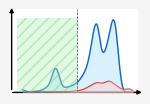


✅ 相似性分布图已保存到: figure/US_figure/similarity.png

Log-Density 相似性分析
📊 数据概览:
  参考正样本: 10,473 个
  查询样本: 70,337 个

🎯 参考集关键分位数:
  5%分位数: 40.506
  25%分位数: 48.831
  60%分位数: 55.197

负采样建议:
  5%分位数以下: 11,421 个 (16.2%)
  25%分位数以下: 25,969 个 (36.9%)
  60%分位数以下: 47,148 个 (67.0%)


In [13]:

import joblib
from function import *  
from function.global_varibles import PATHS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from scipy import stats

def visualize_similarity(gmm_pipeline: Pipeline,
                         df_ref_pos: pd.DataFrame,
                         df_query: pd.DataFrame,
                         q_cut: float = 0.05,
                         random_state: int = 42,
                         save_path: str = 'figure/US_figure/similarity.png'):
    """
    极简相似性诊断函数 - 仅显示log-density重叠直方图和3个分位数（5%, 25%, 60%）
    增加拟合曲线及与X轴围成的阴影，ref为绿色，query为#E28D8D，直方图无框线。
    分位数线带箭头水平线从Y轴指向分位数线，标签居中于两分位数线之间。
    支持图片保存到 save_path。
    """
    # ref淡绿色
    ref_color = '#FFCDD2'  # 淡红色
    ref_kde_color = '#C62828'  # 深红
    # query淡蓝色
    query_color = '#B3E5FC'  # 淡蓝色
    query_kde_color = '#1565C0'  # 深蓝

    pre = gmm_pipeline.named_steps['preprocessor']
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']

    Xr = pre.transform(df_ref_pos)
    Xq = pre.transform(df_query)
    logp_ref = gmm.score_samples(Xr)
    logp_q = gmm.score_samples(Xq)

    quantiles = [0.05, 0.25, 0.60]
    quantile_vals = [float(np.quantile(logp_ref, q)) for q in quantiles]
    mu, std = float(np.mean(logp_ref)), float(np.std(logp_ref) + 1e-12)
    z_q = (logp_q - mu) / std

    fig, ax = plt.subplots(1, 1, figsize=(50/25.4, 35/25.4))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 6
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.labelcolor'] = 'black'
    plt.rcParams['ytick.labelcolor'] = 'black'

    ref_clip, bins_ref, _ = _hist_bins_clip(logp_ref)
    q_clip,   bins_q,   _ = _hist_bins_clip(logp_q)
    bins = max(bins_ref, bins_q)

    # 不显示样本数量
    n_ref, bins_ref_edges, _ = ax.hist(ref_clip, bins=bins, alpha=0.0, label=None, 
            color=ref_color, edgecolor='none', linewidth=0.0)
    n_q, bins_q_edges, _ = ax.hist(q_clip, bins=bins, alpha=0.0, label=None, 
            color=query_color, edgecolor='none', linewidth=0.0)

    x_min = min(np.min(ref_clip), np.min(q_clip))
    x_max = max(np.max(ref_clip), np.max(q_clip))
    x = np.linspace(x_min, x_max, 500)

    # ref绿色放在更上一层，先画query再画ref
    kde_q = stats.gaussian_kde(q_clip)
    y_q = kde_q(x)
    ax.plot(x, y_q * len(q_clip) * (bins_q_edges[1] - bins_q_edges[0]), color=query_kde_color, lw=1, label='Predicting sets')
    ax.fill_between(x, 0, y_q * len(q_clip) * (bins_q_edges[1] - bins_q_edges[0]), color=query_color, alpha=0.5)

    kde_ref = stats.gaussian_kde(ref_clip)
    y_ref = kde_ref(x)
    ax.plot(x, y_ref * len(ref_clip) * (bins_ref_edges[1] - bins_ref_edges[0]), color=ref_kde_color, lw=1, label='Training sets')
    ax.fill_between(x, 0, y_ref * len(ref_clip) * (bins_ref_edges[1] - bins_ref_edges[0]), color=ref_color, alpha=0.5, zorder=10)

    color = '#444444'
    labels = ['5%', '25%', '60%']
    y_max = ax.get_ylim()[1]
    y_arrow = y_max * 0.95

    # 只绘制第一个
    ax.axvline(quantile_vals[0], color=color, linestyle="--", linewidth=0.5, label=f"{labels[0]} quantile")

    # 修改：在0-5%之间添加阴影区域，并让fill_between和箭头的起始点一致
    prev_x = ax.get_xlim()[0]
    x_min_shadow = prev_x  
    x_max_shadow = quantile_vals[0]  
    y_max_shadow = ax.get_ylim()[1]
    
    # Use a light green color for the interval and add shading
    # 先绘制阴影区域
    # 使用斜线阴影 (hatch) 填充0-5%区间
    ax.fill_between([x_min_shadow, x_max_shadow], 0, y_max_shadow*0.9, 
                    color='#b2f2bb', alpha=0.4, zorder=5, hatch='///', edgecolor='#7bc47f', linewidth=0.0)

    # # 再绘制箭头，zorder设为更高，确保箭头在fill_between上方
    # ax.annotate(
    #     '', 
    #     xy=(quantile_vals[0], y_arrow), 
    #     xytext=(x_min_shadow, y_arrow), 
    #     arrowprops=dict(arrowstyle="->", color=color, lw=0.5, zorder=10),
    #     annotation_clip=False
    # )
    # 将整个画布背景设置为灰色
    fig = ax.get_figure()
    fig.patch.set_facecolor('#f5f5f5')
    # ax.set_facecolor('#f5f5f5')
    # 将画布和坐标轴铺满整个页面
    ax.set_position([0, 0, 1, 1])

    x0 = ax.get_xlim()[0]
    xpos = (x0 + quantile_vals[0]) / 2
    # ax.text(
    #     xpos*1.02, y_arrow*1.05, 
    #     f"{labels[0]} quantile", 
    #     color='black', fontsize=5, ha='center', va='bottom', fontweight='bold', zorder=6
    # )
    # ax.text(
    #     xpos*1.02, y_arrow*0.92, 
    #     f"{'low similarity'}", 
    #     color='black', fontsize=5, ha='center', va='bottom', fontweight='bold'
    # )

    ax.grid(False) 
    ax.tick_params(axis='both', which='major', width=0.5, length=2, labelsize=6, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # 修改：取消y轴显示
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])  
    ax.set_xticks([])
    # ax.tick_params(axis='y', which='both', left=False, labelleft=False)  

    ax.annotate('', xy=(1.05, 0), xycoords='axes fraction', xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    ax.annotate('', xy=(0, 1.05), xycoords='axes fraction', xytext=(0, 0),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1, fill=True))
    plt.tight_layout()



    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ 相似性分布图已保存到: {save_path}")

    print("\n" + "="*60)
    print("Log-Density 相似性分析")
    print("="*60)
    print(f"📊 数据概览:")
    print(f"  参考正样本: {len(logp_ref):,} 个")
    print(f"  查询样本: {len(logp_q):,} 个")
    print(f"\n🎯 参考集关键分位数:")
    print(f"  5%分位数: {quantile_vals[0]:.3f}")
    print(f"  25%分位数: {quantile_vals[1]:.3f}")
    print(f"  60%分位数: {quantile_vals[2]:.3f}")

    below_5pct = np.sum(logp_q < quantile_vals[0])  # 应该统计"小于"的数量
    below_25pct = np.sum(logp_q < quantile_vals[1])
    below_60pct = np.sum(logp_q < quantile_vals[2])
    print(f"\n负采样建议:")
    print(f"  5%分位数以下: {below_5pct:,} 个 ({100*below_5pct/len(logp_q):.1f}%)")
    print(f"  25%分位数以下: {below_25pct:,} 个 ({100*below_25pct/len(logp_q):.1f}%)")
    print(f"  60%分位数以下: {below_60pct:,} 个 ({100*below_60pct/len(logp_q):.1f}%)")
    print("="*60)

    return {
        "logp_ref_mean": mu, 
        "logp_ref_std": std,
        "logp_thresholds": dict(zip(labels, quantile_vals)),
        "z_query": z_q,
        "below_5pct_count": below_5pct,
        "below_25pct_count": below_25pct,
        "below_60pct_count": below_60pct
    }


print("\n[载入模型] gmm_model_23c_fixed.pkl ...")
try:
    gmm_pipeline = joblib.load("gmm_model_23c_fixed.pkl")
    print("✅ GMM pipeline loaded.")
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    raise

print("Running similarity diagnostics (log-density/PIT/PCA/MD²)...")
try:
    diag_out = visualize_similarity(
        gmm_pipeline,
        df_ref_pos=df_embedding_fill[features_no_coords],
        df_query=df_abandon_filtered[features_no_coords],
        q_cut=0.05,
        random_state=42,
        save_path='figure/US_figure/similarity.png'
    )
except NameError as e:
    print("⚠️ 找不到 visualize_similarity，请确认该函数已在 function.py 或本文件中定义。")
    print(f"   详细信息: {e}")
except Exception as e:
    print(f"⚠️ 相似性诊断绘图失败: {e}")

# 2、Plot for Component-feature

请你检查select_and_train_gmm函数中的保存参数。我现在需要生成两幅图。

第一是Component–Feature 层，核心目的是用每个 component 的参数刻画特征组合（从PV训练中获取：给人呈现出光伏到底有怎么样的环境结构、有多少类型、哪个环境结构主导了PV部署）

数据输入：训练好的pkl模型（保存的具体参数请参考select_and_train_gmm保存内容）
（1）第 k 个成分的均值向量；
（2）协方差矩阵
（3）混合权重
（4）特征名称


图形输出：（由于我有15个特征、34个高斯组分，因此需要考虑哪个特征组合是真正的主导、占比更高）；各成分在 15 个特征上的标准化均值

(注意由于我对land-cover进行了one-hot编码，需要你对这个特征进行合成)




## 2.1 PV environmental combination

In [2]:
import joblib
import numpy as np
import pandas as pd
import os
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def assign_gmm_components_and_hierarchical_clusters(
    model_path: str = "gmm_model_34c_fixed.pkl",
    df_embedding_fill: pd.DataFrame = None,
    features_no_coords: list = None,
    distance_threshold: float = 1.5,
    save_path: str = "data/US_data/df_pv_gmm.csv"
):
    """
    为df_embedding_fill分配GMM组件编号和层次聚类类别，保留计算去掉绘图。
    """
    # ========== 1. 加载模型和提取参数 ==========
    print(f"Loading model: {model_path}")
    gmm_pipeline = joblib.load(model_path)
    
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    n_components = gmm.n_components
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    
    print(f"\n=== GMM Parameter Information ===")
    print(f"Number of components: {n_components}")
    print(f"Sum of weights: {weights.sum():.6f}")
    print(f"Weight range: [{weights.min():.4f}, {weights.max():.4f}]")
    
    # ========== 2. 处理特征名称和landcover拆解 ==========
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    # Landcover分类定义（基于ESA CCI重分类）
    landcover_to_pattern = {
        1: ['Socioeconomic'],
        2: ['Geographic'],
        3: ['Geographic'],
        4: ['Geographic'],
        5: ['Geographic'],
        6: ['Climatic'],
        7: ['Socioeconomic', 'Infrastructure'],
        8: ['Geographic'],
        9: ['Climatic'],
    }
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        n_landcover_cats = landcover_means.shape[1]
        
        dominant_landcover_idx = np.argmax(landcover_means, axis=1)
        landcover_dominant_values = np.take_along_axis(
            landcover_means, 
            dominant_landcover_idx[:, np.newaxis], 
            axis=1
        ).squeeze()
        
        component_features_std = np.column_stack([
            means[:, :n_numeric],
            landcover_dominant_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
        landcover_means = None
    
    all_features = numeric_features + categorical_features
    
    # ========== 3. 层次聚类分析 ==========
    print(f"\n=== Hierarchical Clustering Analysis ===")
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # 使用距离阈值进行聚类
    cluster_labels = fcluster(linkage_matrix, distance_threshold, criterion='distance')
    n_clusters = len(np.unique(cluster_labels))
    
    print(f"Distance threshold: {distance_threshold}")
    print(f"Number of clusters: {n_clusters}")
    
    # 统计每个聚类的组件分布
    cluster_component_map = {}
    for i in range(1, n_clusters + 1):
        components_in_cluster = np.where(cluster_labels == i)[0]
        cluster_component_map[i] = components_in_cluster.tolist()
        print(f"Cluster {i}: Components {components_in_cluster}")
    
    # ========== 4. 为df_embedding_fill分配GMM组件 ==========
    print(f"\n=== Assigning GMM Components to df_embedding_fill ===")
    
    # 预处理数据
    X_processed = preprocessor.transform(df_embedding_fill[features_no_coords])
    
    # 预测GMM组件
    gmm_components = gmm.predict(X_processed)
    
    # 计算概率分布
    gmm_probabilities = gmm.predict_proba(X_processed)
    max_probabilities = np.max(gmm_probabilities, axis=1)
    
    print(f"Data points assigned to GMM components:")
    print(f"Total data points: {len(df_embedding_fill)}")
    print(f"Component assignment range: [{gmm_components.min()}, {gmm_components.max()}]")
    
    # 统计每个组件的分配情况
    component_counts = pd.Series(gmm_components).value_counts().sort_index()
    print(f"\nComponent distribution:")
    for comp_id, count in component_counts.items():
        pct = count / len(gmm_components) * 100
        print(f"  Component {comp_id}: {count} points ({pct:.2f}%)")
    
    # ========== 5. 分配层次聚类类别 ==========
    print(f"\n=== Assigning Hierarchical Cluster Labels ===")
    
    # 将GMM组件映射到层次聚类类别
    hierarchical_clusters = np.zeros_like(gmm_components)
    for cluster_id, component_list in cluster_component_map.items():
        mask = np.isin(gmm_components, component_list)
        hierarchical_clusters[mask] = cluster_id
    
    # 统计层次聚类分布
    cluster_counts = pd.Series(hierarchical_clusters).value_counts().sort_index()
    print(f"\nHierarchical cluster distribution:")
    for cluster_id, count in cluster_counts.items():
        pct = count / len(hierarchical_clusters) * 100
        print(f"  Cluster {int(cluster_id)}: {count} points ({pct:.2f}%)")
    
    # ========== 6. 分析每个层次聚类的特征模式 ==========
    print(f"\n=== Cluster Feature Pattern Analysis ===")
    
    for cluster_id in range(1, n_clusters + 1):
        cluster_mask = hierarchical_clusters == cluster_id
        cluster_components = cluster_component_map[cluster_id]
        
        print(f"\nCluster {cluster_id} (Components: {cluster_components}):")
        print(f"  Data points: {cluster_mask.sum()}")
        
        # 分析该聚类的特征模式
        cluster_features = component_features_std[cluster_components, :]
        
        # 计算每个特征的平均z-score
        mean_z_scores = np.mean(cluster_features, axis=0)
        
        # 找出显著高于/低于平均的特征
        high_features = []
        low_features = []
        
        for i, feature in enumerate(all_features):
            z_score = mean_z_scores[i]
            if z_score > 0.5:  # 显著高于平均
                high_features.append((feature, z_score))
            elif z_score < -0.5:  # 显著低于平均
                low_features.append((feature, z_score))
        
        if high_features:
            print(f"  High features (z > 0.5):")
            for feature, z in sorted(high_features, key=lambda x: x[1], reverse=True):
                print(f"    {feature}: {z:.3f}")
        
        if low_features:
            print(f"  Low features (z < -0.5):")
            for feature, z in sorted(low_features, key=lambda x: x[1]):
                print(f"    {feature}: {z:.3f}")
    
    # ========== 7. 创建结果DataFrame ==========
    print(f"\n=== Creating Result DataFrame ===")
    
    # 确保df_embedding_fill包含lat和lon列
    if 'lat' not in df_embedding_fill.columns or 'lon' not in df_embedding_fill.columns:
        raise ValueError("df_embedding_fill must contain 'lat' and 'lon' columns")
    
    # 重置索引以确保索引连续
    df_embedding_fill_reset = df_embedding_fill.reset_index(drop=True)
    
    # 创建结果DataFrame
    df_result = df_embedding_fill_reset.copy()
    
    # 添加GMM相关信息
    df_result['gmm_component'] = gmm_components
    df_result['gmm_max_probability'] = max_probabilities
    df_result['hierarchical_cluster'] = hierarchical_clusters
    
    # 添加层次聚类的描述性信息
    cluster_descriptions = {}
    for cluster_id in range(1, n_clusters + 1):
        cluster_components = cluster_component_map[cluster_id]
        component_str = ','.join(map(str, cluster_components))
        cluster_descriptions[cluster_id] = f"Cluster_{cluster_id}_Components_{component_str}"
    
    df_result['cluster_description'] = df_result['hierarchical_cluster'].map(cluster_descriptions)
    
    print(f"Result DataFrame shape: {df_result.shape}")
    print(f"Columns added: gmm_component, gmm_max_probability, hierarchical_cluster, cluster_description")
    
    # ========== 8. 保存结果 ==========
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df_result.to_csv(save_path, index=False)
    
    print(f"\n✅ Results saved to: {save_path}")
    
    # 去除所有可视化和绘图部分
    
    return df_result

# 使用示例
if __name__ == "__main__":
    # 假设df_embedding_fill和features_no_coords已经定义
    # 这些变量应该从之前的代码中获取
    
    # 示例用法（需要根据实际情况调整）
    df_result = assign_gmm_components_and_hierarchical_clusters(
        model_path="gmm_model_23c_fixed.pkl",
        df_embedding_fill=df_embedding_fill,  # 从之前代码获取
        features_no_coords=features_no_coords,  # 从之前代码获取
        distance_threshold=1.5,
        save_path="data/US_data/df_pv_gmm.csv"
    )
    
    print(f"\n✅ 完成！结果已保存到 data/US_data/df_pv_gmm.csv")
    print(f"DataFrame包含列: {list(df_result.columns)}")

NameError: name 'df_embedding_fill' is not defined

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from matplotlib.patches import Rectangle, Patch
import matplotlib.gridspec as gridspec

'''
规则1: 主导型 (Dominant)
- 第一名 > 55%

规则2: 四重混合 (Mixed-Quad)  
- 四种模式都 > 12%
- 第一名 < 40%

规则3: 三重混合 (Mixed-Triple)
- 前三名都 > 15%
- 第一名 < 50%

规则4: 双重混合 (Mixed-Dual)
- 前两名都 > 20%
- 第一名 < 55%
'''

def classify_pattern_type(scores_dict):
    """
    分类component的模式类型（适用于4种模式）
    返回: (pattern_type, patterns_list, ratios_list)
    """
    sorted_scores = sorted(scores_dict.items(), key=lambda x: x[1], reverse=True)
    total = sum(scores_dict.values())
    
    if total < 1e-10:
        return 'Undefined', [None], [1.0]
    
    # 计算归一化得分
    norm_scores = [(name, score/total) for name, score in sorted_scores]
    
    # 获取前四名
    patterns = [norm_scores[i] if i < len(norm_scores) else (None, 0) for i in range(4)]
    
    first_name, first_ratio = patterns[0]
    second_name, second_ratio = patterns[1]
    third_name, third_ratio = patterns[2] if patterns[2][0] else (None, 0)
    fourth_name, fourth_ratio = patterns[3] if patterns[3][0] else (None, 0)
    
    # 规则1: 主导型 - 第一名 > 55%
    if first_ratio > 0.55:
        return 'Dominant', [first_name], [1.0]
    
    # 规则2: 四重混合 - 四种模式都 > 12%，第一名 < 40%
    if (fourth_ratio > 0.12 and first_ratio < 0.40):
        total_top4 = sum([first_ratio, second_ratio, third_ratio, fourth_ratio])
        return 'Mixed-Quad', \
               [first_name, second_name, third_name, fourth_name], \
               [first_ratio/total_top4, second_ratio/total_top4, 
                third_ratio/total_top4, fourth_ratio/total_top4]
    
    # 规则3: 三重混合 - 前三名都 > 15%，第一名 < 50%
    if (third_ratio > 0.15 and first_ratio < 0.50):
        total_top3 = sum([first_ratio, second_ratio, third_ratio])
        return 'Mixed-Triple', \
               [first_name, second_name, third_name], \
               [first_ratio/total_top3, second_ratio/total_top3, third_ratio/total_top3]
    
    # 规则4: 双重混合 - 前两名都 > 20%，第一名 < 55%
    if (second_ratio > 0.20 and first_ratio < 0.55):
        total_top2 = first_ratio + second_ratio
        return 'Mixed-Dual', \
               [first_name, second_name], \
               [first_ratio/total_top2, second_ratio/total_top2]
    
    # 默认：主导型
    return 'Dominant', [first_name], [1.0]


def plot_component_feature_analysis_enhanced_with_weights(
    model_path: str = "gmm_model_34c_fixed.pkl",
    figsize: tuple = (24, 14),
    save_path: str = None,
):
    """
    增强版Component-Feature分析，结合权重计算pattern_type的数据占比
    """
    
    # ========== 1. 加载模型和提取参数 ==========
    print(f"Loading model: {model_path}")
    gmm_pipeline = joblib.load(model_path)
    
    gmm: GaussianMixture = gmm_pipeline.named_steps['gmm']
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    
    n_components = gmm.n_components
    means = gmm.means_
    weights = gmm.weights_
    covariances = gmm.covariances_
    
    print(f"\n=== GMM Parameter Information ===")
    print(f"Number of components: {n_components}")
    print(f"Sum of weights: {weights.sum():.6f} (should ≈1.0)")
    print(f"Weight range: [{weights.min():.4f}, {weights.max():.4f}]")
    
    # ========== 2. 处理特征名称和landcover拆解 ==========
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    # Landcover分类定义（基于ESA CCI重分类）- 细分到4个模式
    landcover_to_pattern = {
        1: ['Socioeconomic'],                    # Cropland → 社会经济
        2: ['Geographic'],                       # Forest → 地理环境
        3: ['Geographic'],                       # Savanna → 地理环境
        4: ['Geographic'],                       # Shrub → 地理环境
        5: ['Geographic'],                       # Grassland → 地理环境
        6: ['Climatic'],                         # Wetland → 气候环境
        7: ['Socioeconomic', 'Infrastructure'],  # Built-up → 共享
        8: ['Geographic'],                       # Bare → 地理环境
        9: ['Climatic'],                         # Water → 气候环境
    }
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        n_landcover_cats = landcover_means.shape[1]
        
        dominant_landcover_idx = np.argmax(landcover_means, axis=1)
        landcover_dominant_values = np.take_along_axis(
            landcover_means, 
            dominant_landcover_idx[:, np.newaxis], 
            axis=1
        ).squeeze()
        
        component_features_std = np.column_stack([
            means[:, :n_numeric],
            landcover_dominant_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
        landcover_means = None
    
    all_features = numeric_features + categorical_features
    
    # ========== 3. 提取方差信息 ==========
    if gmm.covariance_type == 'full':
        variances = np.array([np.diag(covariances[k]) for k in range(n_components)])
    elif gmm.covariance_type == 'diag':
        variances = covariances
    else:
        variances = np.ones_like(means)
    
    if categorical_features:
        landcover_variances = variances[:, n_numeric:]
        variances_for_display = np.column_stack([
            variances[:, :n_numeric],
            landcover_variances.mean(axis=1, keepdims=True)
        ])
    else:
        variances_for_display = variances
    
    # ========== 4. 定义特征组（4种模式） ==========
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],      # 地理环境因素
        'Climatic': ['rsds', 'tas', 'wind'],         # 气候环境因素
    }
    
    # ========== 5. 计算模式得分（含landcover拆解） ==========
    def calculate_pattern_scores(comp_idx):
        scores = {name: 0.0 for name in feature_groups.keys()}
        
        # 数值特征贡献
        for pattern_name, features in feature_groups.items():
            indices = [all_features.index(f) for f in features if f in all_features]
            if indices:
                contrib = np.abs(component_features_std[comp_idx, indices]) * \
                         np.sqrt(variances_for_display[comp_idx, indices]) * \
                         weights[comp_idx]
                scores[pattern_name] += contrib.sum()
        
        # Landcover贡献拆解
        if landcover_means is not None:
            for lc_idx in range(n_landcover_cats):
                lc_class = lc_idx + 1
                if lc_class in landcover_to_pattern:
                    patterns = landcover_to_pattern[lc_class]
                    lc_value = landcover_means[comp_idx, lc_idx]
                    lc_var = landcover_variances[comp_idx, lc_idx]
                    
                    lc_contrib = np.abs(lc_value) * np.sqrt(lc_var) * weights[comp_idx]
                    
                    for pattern in patterns:
                        if pattern in scores:
                            scores[pattern] += lc_contrib / len(patterns)
        
        return scores
    
    # ========== 6. 计算模式得分并统计权重聚合 ==========
    pattern_scores = []
    pattern_types = []
    
    for k in range(n_components):
        scores = calculate_pattern_scores(k)
        pattern_scores.append(scores)
        ptype, patterns, ratios = classify_pattern_type(scores)
        pattern_types.append({
            'type': ptype,
            'patterns': patterns,
            'ratios': ratios,
            'component_weight': weights[k]  # 添加组件权重
        })
    
    pattern_df = pd.DataFrame(pattern_scores)
    
    # ========== 7. 权重聚合统计 ==========
    def calculate_weighted_pattern_distribution(pattern_types, weights):
        """
        计算各个pattern_type的权重聚合分布
        """
        pattern_weight_stats = {}
        
        # 按pattern_type分组
        for ptype in ['Dominant', 'Mixed-Dual', 'Mixed-Triple', 'Mixed-Quad', 'Undefined']:
            pattern_weight_stats[ptype] = {
                'total_weight': 0.0,
                'component_count': 0,
                'components': [],
                'pattern_breakdown': {}  # 对于混合类型，记录各子模式的权重
            }
        
        # 聚合权重
        for k, pt in enumerate(pattern_types):
            ptype = pt['type']
            component_weight = pt['component_weight']
            
            pattern_weight_stats[ptype]['total_weight'] += component_weight
            pattern_weight_stats[ptype]['component_count'] += 1
            pattern_weight_stats[ptype]['components'].append(k)
            
            # 对于混合类型，计算各子模式的权重贡献
            if 'Mixed' in ptype:
                for pattern, ratio in zip(pt['patterns'], pt['ratios']):
                    if pattern not in pattern_weight_stats[ptype]['pattern_breakdown']:
                        pattern_weight_stats[ptype]['pattern_breakdown'][pattern] = 0.0
                    pattern_weight_stats[ptype]['pattern_breakdown'][pattern] += component_weight * ratio
        
        return pattern_weight_stats
    
    # 计算权重分布
    weight_stats = calculate_weighted_pattern_distribution(pattern_types, weights)
    
    # ========== 8. 输出详细的权重统计 ==========
    print(f"\n=== Pattern Type Distribution (Count-based) ===")
    type_counts = {}
    for pt in pattern_types:
        ptype = pt['type']
        type_counts[ptype] = type_counts.get(ptype, 0) + 1
    
    for ptype in ['Dominant', 'Mixed-Dual', 'Mixed-Triple', 'Mixed-Quad', 'Undefined']:
        count = type_counts.get(ptype, 0)
        if count > 0:
            pct = count / n_components * 100
            print(f"{ptype}: {count} components ({pct:.1f}%)")
    
    print(f"\n=== Pattern Type Distribution (Weight-based) ===")
    total_weight = sum(ws['total_weight'] for ws in weight_stats.values())
    
    for ptype in ['Dominant', 'Mixed-Dual', 'Mixed-Triple', 'Mixed-Quad', 'Undefined']:
        ws = weight_stats[ptype]
        if ws['component_count'] > 0:
            weight_pct = ws['total_weight'] / total_weight * 100
            avg_weight = ws['total_weight'] / ws['component_count']
            print(f"{ptype}: {ws['total_weight']:.4f} ({weight_pct:.1f}%) "
                  f"[{ws['component_count']} components, avg_weight={avg_weight:.4f}]")
            
            # 对于混合类型，显示子模式权重分解
            if 'Mixed' in ptype and ws['pattern_breakdown']:
                print(f"  Sub-pattern breakdown:")
                for sub_pattern, sub_weight in sorted(ws['pattern_breakdown'].items(), 
                                                     key=lambda x: x[1], reverse=True):
                    sub_pct = sub_weight / total_weight * 100
                    print(f"    {sub_pattern}: {sub_weight:.4f} ({sub_pct:.1f}%)")
    
    # # ========== 9. 计算各pattern在训练样本中的实际占比 ==========
    # print(f"\n=== Training Sample Coverage Analysis ===")
    
    # 计算各pattern的实际数据占比
    pattern_coverage = {}
    for ptype, ws in weight_stats.items():
        if ws['component_count'] > 0:
            pattern_coverage[ptype] = ws['total_weight']
    
    # # 按权重排序
    sorted_patterns = sorted(pattern_coverage.items(), key=lambda x: x[1], reverse=True)
    
    # print("Pattern coverage in training data (by weight):")
    # for ptype, weight in sorted_patterns:
    #     pct = weight * 100
    #     print(f"  {ptype}: {weight:.4f} ({pct:.1f}% of training samples)")
    
    # # ========== 10. 混合模式的详细分析 ==========
    # print(f"\n=== Mixed Pattern Component Details ===")
    # for k, pt in enumerate(pattern_types):
    #     if 'Mixed' in pt['type']:
    #         scores = pattern_scores[k]
    #         total = sum(scores.values())
    #         details = []
    #         for p, r in zip(pt['patterns'], pt['ratios']):
    #             pct = scores[p] / total * 100 if total > 0 else 0
    #             details.append(f"{p}({pct:.1f}%)")
            
    #         print(f"Component {k} [weight={pt['component_weight']:.4f}]: "
    #               f"{' + '.join(details)} [{pt['type']}]")
    
    # ========== 11. 层次聚类 ==========
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # ========== 12. 可视化（融合dendrogram到热力图） ==========
    fig = plt.figure(figsize=figsize)
    
    # 创建网格：上部dendrogram，中部pattern bar，下部heatmap
    gs = gridspec.GridSpec(3, 1, height_ratios=[0.8, 0.3, 3], hspace=0.05, 
                          left=0.08, right=0.95, top=0.94, bottom=0.08)
    
    # --- 树状图（顶部，增强标题包含权重信息） ---
    ax_dendro = fig.add_subplot(gs[0])
    dendro = dendrogram(
        linkage_matrix,
        ax=ax_dendro,
        no_labels=True,
        color_threshold=0,
        above_threshold_color='gray'
    )
    
    # 增强标题，包含权重信息
    dominant_weight = weight_stats['Dominant']['total_weight'] * 100
    mixed_weight = sum(ws['total_weight'] for ptype, ws in weight_stats.items() 
                      if 'Mixed' in ptype) * 100
    
    ax_dendro.set_title(
        f'Component-Feature Pattern Analysis with Weight Distribution\n'
        f'(Dominant: {dominant_weight:.2f}% | Mixed: {mixed_weight:.2f}% of training data)', 
        fontsize=15, fontweight='bold', pad=15
    )
    ax_dendro.set_xticks([])
    ax_dendro.set_ylabel('Distance', fontsize=10)
    ax_dendro.spines['bottom'].set_visible(False)
    ax_dendro.spines['top'].set_visible(False)
    ax_dendro.spines['right'].set_visible(False)
    
    dendro_order = dendro['leaves']
    
    # --- 模式条（中部，高度反映权重） ---
    ax_pattern = fig.add_subplot(gs[1], sharex=ax_dendro)
    
    pattern_colors = {
        'Socioeconomic': '#FF6B6B',      # 红色
        'Infrastructure': '#4ECDC4',     # 青色
        'Geographic': '#95E1D3',         # 浅绿色（地理环境）
        'Climatic': '#FFA07A',           # 橙色（气候环境）
    }
    
    # 绘制堆叠色块，高度反映权重
    for i, comp_idx in enumerate(dendro_order):
        pt = pattern_types[comp_idx]
        weight = pt['component_weight']
        
        # 根据权重调整色块高度（权重越大，色块越高）
        height_factor = weight / weights.max()  # 归一化到[0,1]
        
        if pt['type'] == 'Dominant':
            color = pattern_colors.get(pt['patterns'][0], 'gray')
            ax_pattern.add_patch(Rectangle((i*10, 0), 10, height_factor, 
                                          facecolor=color, edgecolor='white', linewidth=0.5))
        else:
            cumulative_height = 0
            for pattern, ratio in zip(pt['patterns'], pt['ratios']):
                color = pattern_colors.get(pattern, 'gray')
                height = ratio * height_factor
                ax_pattern.add_patch(Rectangle((i*10, cumulative_height), 10, height, 
                                              facecolor=color, edgecolor='white', linewidth=0.5))
                cumulative_height += height
    
    ax_pattern.set_xlim(ax_dendro.get_xlim())
    ax_pattern.set_ylim(0, 1)
    ax_pattern.set_yticks([])
    ax_pattern.set_xticks([])
    ax_pattern.set_ylabel('Pattern\n(Height∝Weight)', fontsize=9, rotation=0, ha='right', va='center')
    ax_pattern.spines['top'].set_visible(False)
    ax_pattern.spines['bottom'].set_visible(False)
    ax_pattern.spines['left'].set_visible(False)
    ax_pattern.spines['right'].set_visible(False)
    
    # --- 热力图（底部，x轴标签包含权重和模式类型信息） ---
    ax_heatmap = fig.add_subplot(gs[2], sharex=ax_dendro)
    
    heatmap_data = component_features_std[dendro_order, :].T
    
    # 使用extent来对齐x轴
    extent = [ax_dendro.get_xlim()[0], ax_dendro.get_xlim()[1], 
              len(all_features), 0]
    
    im = ax_heatmap.imshow(heatmap_data, cmap='RdBu_r', aspect='auto', 
                           vmin=-3, vmax=3, interpolation='nearest',
                           extent=extent)
    
    # x轴标签包含权重和pattern类型信息
    x_positions = [(i + 0.5) * 10 for i in range(n_components)]
    labels = []
    for i in range(n_components):
        comp_idx = dendro_order[i]
        weight = weights[comp_idx]
        pt = pattern_types[comp_idx]
        ptype_short = pt['type'].replace('Mixed-', 'M').replace('Dominant', 'D')
        labels.append(f'C{comp_idx}\nw={weight:.2f}\n{ptype_short}')
    
    ax_heatmap.set_xticks(x_positions)
    ax_heatmap.set_xticklabels(labels, fontsize=6, rotation=90)
    
    # 设置y轴标签
    ax_heatmap.set_yticks(np.arange(len(all_features)) + 0.5)
    ax_heatmap.set_yticklabels(all_features, fontsize=10)
    
    ax_heatmap.set_xlabel('Components (ordered by hierarchical clustering, with mixture weights)', 
                          fontsize=12, fontweight='bold')
    ax_heatmap.set_ylabel('Features', fontsize=12, fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax_heatmap, fraction=0.015, pad=0.02)
    cbar.set_label('Standardized Mean (z-score)\nPositive=Above avg, Negative=Below avg', 
                   fontsize=9)
    
    # 图例（放在右侧）
    legend_elements = []
    for pattern, color in pattern_colors.items():
        legend_elements.append(Patch(facecolor=color, label=pattern, edgecolor='white'))
    legend_elements.append(Patch(facecolor='lightgray', edgecolor='white', 
                                 label='Mixed (stacked)', linewidth=1.5))
    
    # 将图例放在热力图右侧
    ax_heatmap.legend(handles=legend_elements, loc='center left', 
                     bbox_to_anchor=(1.12, 0.5), frameon=True, 
                     fontsize=10, title='Pattern Type\n(4 Categories)', title_fontsize=11)
    
    # ========== 13. 输出最终统计摘要 ==========
    print(f"\n=== Final Summary ===")
    print(f"Total components: {n_components}")
    print(f"Total weight sum: {weights.sum():.6f}")
    print(f"Pattern type coverage in training data:")
    for ptype, weight in sorted_patterns:
        pct = weight * 100
        count = weight_stats[ptype]['component_count']
        print(f"  {ptype}: {pct:.2f}% ({count} components)- Calculated by weights sum")
    
    # ========== 14. 输出其他统计信息 ==========
    print(f"\n=== Pattern Contribution (4-Pattern System) ===")
    total_contrib = pattern_df.sum(axis=0).sort_values(ascending=False)
    for pattern, contrib in total_contrib.items():
        pct = contrib / total_contrib.sum() * 100
        print(f"{pattern}: {contrib:.4f} ({pct:.2f}%)")
    
    # print(f"\n=== Landcover Decomposition Mapping ===")
    # print("Cropland (1) → Socioeconomic")
    # print("Forest/Savanna/Shrub/Grassland/Bare (2,3,4,5,8) → Geographic")
    # print("Wetland/Water (6,9) → Climatic")
    # print("Built-up (7) → Socioeconomic (50%) + Infrastructure (50%)")
    
    # print(f"\n=== Classification Rules (4-Pattern System) ===")
    # print("Dominant: First pattern > 55%")
    # print("Mixed-Dual: Top 2 patterns > 20%, first < 55%")
    # print("Mixed-Triple: Top 3 patterns > 15%, first < 50%")
    # print("Mixed-Quad: All 4 patterns > 12%, first < 40%")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    return fig, pattern_df, dendro_order, pattern_types, weight_stats


# 使用示例
if __name__ == "__main__":
    fig, pattern_df, order, ptypes, weights = plot_component_feature_analysis_enhanced_with_weights(
        model_path="gmm_model_23c_fixed.pkl",
        figsize=(24, 14),
        save_path="figure/US_figure/component_feature_weighted_analysis.png"
    )
    plt.show()

Loading model: gmm_model_23c_fixed.pkl
gogogo
[OK] TensorFlow available
[OK] scikeras available
[OK] SHAP available

=== GMM Parameter Information ===
Number of components: 23
Sum of weights: 1.000000 (should ≈1.0)
Weight range: [0.0014, 0.1337]

=== Pattern Type Distribution (Count-based) ===
Dominant: 7 components (30.4%)
Mixed-Dual: 5 components (21.7%)
Mixed-Triple: 6 components (26.1%)
Mixed-Quad: 5 components (21.7%)

=== Pattern Type Distribution (Weight-based) ===
Dominant: 0.1413 (14.1%) [7 components, avg_weight=0.0202]
Mixed-Dual: 0.3320 (33.2%) [5 components, avg_weight=0.0664]
  Sub-pattern breakdown:
    Infrastructure: 0.1958 (19.6%)
    Socioeconomic: 0.1070 (10.7%)
    Climatic: 0.0291 (2.9%)
Mixed-Triple: 0.2707 (27.1%) [6 components, avg_weight=0.0451]
  Sub-pattern breakdown:
    Climatic: 0.0910 (9.1%)
    Geographic: 0.0890 (8.9%)
    Infrastructure: 0.0539 (5.4%)
    Socioeconomic: 0.0369 (3.7%)
Mixed-Quad: 0.2561 (25.6%) [5 components, avg_weight=0.0512]
  Sub-p

C:\Users\zpy10\AppData\Local\Temp\ipykernel_32388\366475328.py:493: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
